In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread
import scipy.stats as st
import glob, os
import numpy as np
import pandas as pd
import seaborn as sns
import csv
sns.set_style("whitegrid")
import pingouin as pg

# The psychophysics of empathy
Sarra Zaied, Catherine Soladié, Jean-Julien Aucouturier, 2019-2022

_Empathy, theory of mind and imitation, all key building blocks of human social cognition, are thought to rely mechanistically on overlapping representations between the self and the others, but the extent and informational content of such overlap has been difficult to quantify experimentally. Here, we report on a novel psychophysical paradigm in which real photographs of participants' own faces can be manipulated algorithmically to generate arbitrary facial expressions. Using reverse-correlation, we show that we can reconstruct what sensory representations subserved participants' perception of their and another person's smiling face, in a way that can be compared within and across participants. Using this procedure, we show that participants’ mental representations of their own smiling face generally matched the representations they had of others', but were unrelated to how participants actually smiled. Strikingly, similarities between self- and other-representations correlated with participant empathy and alexithymia: participants high on empathy mentally represented others as more similar to themselves, and participants low on alexithymia more accurately represented how they actually smile_. 

## Materials and methods

In [2]:
POINTS = [137,138,139,140,141,53,54,55,
          56,64,70,67,73,45,46,17,20,23,
          52,51,35,32,29] #index of the manipulated face points, listed in that order in stimulus info files
LIP_POINTS = [64,67,70,73]
NOSE_POINTS = [53,54,55,56]
EYE_POINTS = [45,46,51,52]
BROW_POINTS = [17,20,23,29,32,35]
FORHEAD_POINTS = [137,138,139,140,141]
POINT_GROUPS={'Lips':[64,67,70,73], 
              'Nose':[53,54,55,56], 
              'Eyes':[45,46,51,52],
              'Brows':[17,20,23,29,32,35],
              "Forhead": [137,138,139,140,141]}

c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# utility function to load x or y coordinates from a kernel or stim file
def get_coordinate(file_name, point, x_or_y):
    info = []
    with open(file_name,'r') as file:
        reader = csv.reader(file)
        for row in reader:
            info.append(float(row[0]))
    # skip to index corresponding to point    
    x = info[0::2][POINTS.index(point)]
    y = info[1::2][POINTS.index(point)]
    if x_or_y=='x':
        return x
    else:
        return y    

### Production task

We analysed each participant's video manually to extract two static frames: one of the participant's neutral/resting face, and one at the apex of the smile expression. We then used video face tracking software ([Dynamixyz](https://www.dynamixyz.com)) to detect the boundaries of the participant's face; crop, rotate and resize the two photographs to isolate the face region and normalize its coordinates in the 2D plan; and finally extracted the 2D coordinates of 23 facial landmarks on the left eye (2 points), left eyebrow (3), right eye (2), right eyebrow (3), nose (4), forehead (5) and mouth (4). 

In [4]:
SUBJECTS=range(1,25)
subjects=[]
points = []
for subj in SUBJECTS:
    for point in POINTS: 
        subjects.append(subj)
        points.append(point)
data=pd.DataFrame.from_dict({'subj':subjects,'point':points})


In [5]:
# get neutral and smile frame coordinates

data['x_neutral'] = data.apply(lambda row: get_coordinate('./data/production/neutral%d.txt'%(row['subj']),
                                                          row['point'],'x'), axis=1)
data['y_neutral'] = data.apply(lambda row: get_coordinate('./data/production/neutral%d.txt'%(row['subj']),
                                                          row['point'],'y'), axis=1)
data['x_smile'] = data.apply(lambda row: get_coordinate('./data/production/smile%d.txt'%(row['subj']),
                                                        row['point'],'x'), axis=1)
data['y_smile'] = data.apply(lambda row: get_coordinate('./data/production/smile%d.txt'%(row['subj']),
                                                        row['point'],'y'), axis=1)

In [6]:
# compute difference coordinates per actor point
data['delta_x']=data['x_smile']-data['x_neutral']
data['delta_y']=data['y_smile']-data['y_neutral']

# kernels then normalized for each subj/actor by dividing them 
# by the RMS of their values over all points 
data['square_delta_x'] = data['delta_x']**2
data['square_delta_y'] = data['delta_y']**2
for_norm = data.groupby(['subj']).agg({'square_delta_x':'mean',
                                       'square_delta_y':'mean'}).reset_index()
data = pd.merge(data, for_norm, on=['subj'], suffixes=['','_mean'])
data['norm_delta_x'] = data['delta_x']/np.sqrt(data['square_delta_x_mean'])
data['norm_delta_y'] = data['delta_y']/np.sqrt(data['square_delta_y_mean'])
data.drop(['square_delta_x','square_delta_y','square_delta_x_mean','square_delta_y_mean'], axis=1, inplace=True)

In [7]:
# save figs and kernels for all participants
subjects = data.subj.unique()

gain=10 # for visualization only

for subj_index, subject in enumerate(subjects): #subjects in cols
    
    print('subject '+str(subject)+', ', end='')
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    for index, row in data[data.subj==subject].iterrows():
    
        # display neutral
        g1=plt.scatter(row['x_neutral'],row['y_neutral'], color='black', marker='^',zorder=2)
        ax.text(row['x_neutral'], row['y_neutral'], str(int(row['point'])), fontsize=7)
    
        # display displaced
        g2=plt.scatter(row['x_neutral']+gain*row['norm_delta_x'],
                       row['y_neutral']+gain*row['norm_delta_y'], color='red', marker='^', zorder=2)
        ax.text(row['x_neutral']+gain*row['norm_delta_x'],
                row['y_neutral']+gain*row['norm_delta_y'], str(int(row['point'])), fontsize=7)
    
        # display line between points
        plt.plot([row['x_neutral'],row['x_neutral']+gain*row['norm_delta_x']],
                 [row['y_neutral'], row['y_neutral']+gain*row['norm_delta_y']],
                 color='black', zorder=1)
            
    img = imread('../experiment/revcor-self/stims/Actor'+str(int(subject))+'/neutral.jpg')
    plt.imshow(img, zorder=0)
    plt.title('Subject '+str(subject))
    fig.savefig('./kernels/production/Subject'+str(subject)+'.png')
    plt.close(fig)
        
    # write actor-specific displacement to kernel file
    kernel_file = './kernels/production/Subject'+str(subject)+'.txt'
    with open(kernel_file, 'w+',newline='') as file:
        writer = csv.writer(file)            
        for point in POINTS:
            delta_x = data[(data.subj==subject)&(data.point==point)]['norm_delta_x'].iloc[0]
            delta_y = data[(data.subj==subject)&(data.point==point)]['norm_delta_y'].iloc[0]
            writer.writerow([delta_x])
            writer.writerow([delta_y])
            #print('subject%d, point:%d, delta_x:%f, delta_y:%f'%(subject,point,delta_x, delta_y))

subject 1, subject 2, subject 3, subject 4, subject 5, subject 6, subject 7, subject 8, subject 9, subject 10, subject 11, subject 12, subject 13, subject 14, subject 15, subject 16, subject 17, subject 18, subject 19, subject 20, subject 21, subject 22, subject 23, subject 24, 

### Other perception task

For each participant and each task, we computed first-order kernels from reverse-correlation data
using the classification image method. We computed the average random (x,y) displacement
for each of the 23 landmarks in the n=700 photographs classified as affiliative, and subtracted
the average random displacement of the photographs classified as non-affiliative. Kernels were
then normalized by dividing them by the absolute sum of their values. For each participant, this
procedure resulted in a 2$\times$23 vector of (x,y) coordinates, of the same format as the participants’
Production kernels (see above), and representing the displacement to be applied to a given
photograph in order to increase the probability that the resulting face be selected as affiliative
by a given participa

#### Load data

In [8]:
data_dir = 'data/revcor-actors/'
data_files = glob.glob(data_dir+"results_Subj*.csv.gz")
print(len(data_files))
data = pd.DataFrame()
for data_file in data_files:
    participant_data = pd.read_csv(data_file, sep = ',', decimal='.', header='infer', compression='gzip')
    data = data.append(participant_data, ignore_index=True)

24


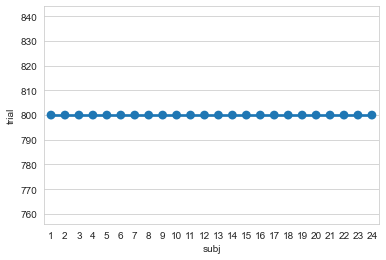

In [9]:
# all subjects have 800 trials (no trial missing)
d=data[data.practice==False].groupby(['subj']).agg({'trial':'count'})/(data.actor.nunique()*data.point.nunique())
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

#### Demographics

In [10]:
data.groupby('subj').age.mean().mean()

23.875

In [11]:
data.groupby(['sex']).subj.nunique()

sex
f    12
m    12
Name: subj, dtype: int64

#### Compute kernels, averaged for each participant

In [12]:
# exclude practice blocks and repeated blocks
all_data = data.copy()
data = data[data.practice==False]
data = data[~data.block.isin([9,17])]

In [13]:
# average coordinates per actor point true&false
averaged_data = data.groupby(['subj','actor','point','response']).agg({'x':'mean','y':'mean'}).reset_index()
positives = averaged_data.loc[averaged_data['response'] == True].reset_index()
negatives = averaged_data.loc[averaged_data['response'] == False].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','actor','point'],suffixes=['+','-'])

# compute difference coordinates per actor point
kernels['delta_x']=kernels['x+']-kernels['x-']
kernels['delta_y']=kernels['y+']-kernels['y-']
kernels.drop(['index+','index-','response+','response-','x+','y+','x-','y-'], axis=1, inplace=True)

# kernels then normalized for each subj/actor by dividing them 
# by the RMS of their values over all points 
kernels['square_delta_x'] = kernels['delta_x']**2
kernels['square_delta_y'] = kernels['delta_y']**2
for_norm = kernels.groupby(['subj','actor']).agg({'square_delta_x':'mean',
                                                  'square_delta_y':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','actor'], suffixes=['','_mean'])
kernels['norm_delta_x'] = kernels['delta_x']/np.sqrt(kernels['square_delta_x_mean'])
kernels['norm_delta_y'] = kernels['delta_y']/np.sqrt(kernels['square_delta_y_mean'])
kernels.drop(['square_delta_x','square_delta_y','square_delta_x_mean','square_delta_y_mean'], axis=1, inplace=True)

In [14]:
# add neutral point coordinates

POINTS = [137,138,139,140,141,53,54,55,
          56,64,70,67,73,45,46,17,20,23,
          52,51,35,32,29] #index of the manipulated face points, listed in that order in stimulus info files
    
kernels['x_neutral'] = kernels.apply(lambda row: get_coordinate('../experiment/revcor-actors/stims/Actor%d/neutral.txt'%(row['actor']),
                                                                row['point'],'x'), axis=1)
kernels['y_neutral'] = kernels.apply(lambda row: get_coordinate('../experiment/revcor-actors/stims/Actor%d/neutral.txt'%(row['actor']),
                                                                row['point'],'y'), axis=1)


In [15]:
# add displacement (+ vs -) averaged over both actors

kernels_averaged_over_actors = kernels.groupby(['subj','point']).agg({'norm_delta_x' : 'mean',
                                                               'norm_delta_y' : 'mean'}).reset_index()
kernels = pd.merge(kernels, kernels_averaged_over_actors,
                   on=['subj','point'], suffixes=['','_grouped'])


#### Save kernels

In [16]:
# save figs and kernels for all participants

subjects = kernels.subj.unique()
actors = kernels.actor.unique()

#index of the manipulated face points, listed in that order in stimulus info files
POINTS = [137,138,139,140,141,53,54,55,56,64,70,67,73,45,46,17,20,23, 52,51,35,32,29] 

gain=10 # for visualization only

for subj_index, subject in enumerate(subjects): #subjects in cols
    
    print('subject '+str(subject)+', ', end='')
    for actor_index, actor in enumerate(actors): #actors in rows
    
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        
        for index, row in kernels[(kernels.subj==subject)&(kernels.actor==actor)].iterrows():
    
            # display neutral
            g1=plt.scatter(row['x_neutral'],row['y_neutral'], color='black', marker='^',zorder=2)
            ax.text(row['x_neutral'], row['y_neutral'], str(int(row['point'])), fontsize=7)
    
            # display displaced
            g2=plt.scatter(row['x_neutral']+gain*row['norm_delta_x'],
                           row['y_neutral']+gain*row['norm_delta_y'], color='red', marker='^', zorder=2)
            ax.text(row['x_neutral']+gain*row['norm_delta_x'],
                    row['y_neutral']+gain*row['norm_delta_y'], str(int(row['point'])), fontsize=7)
    
            # display line between points
            plt.plot([row['x_neutral'],row['x_neutral']+gain*row['norm_delta_x']],
                     [row['y_neutral'], row['y_neutral']+gain*row['norm_delta_y']],
                     color='black', zorder=1)
            
        img = imread('../experiment/revcor-actors/stims/Actor'+str(int(actor))+'/neutral.jpg')
        plt.imshow(img, zorder=0)
        plt.title('Subject '+str(subject))
        fig.savefig('./kernels/revcor-actors/Subject'+str(subject)+'_Actor'+str(actor)+'.png')
        plt.close(fig)
        
        # write actor-specific displacement to kernel file
        kernel_file = './kernels/revcor-actors/Subject'+str(subject)+'_Actor'+str(actor)+'.txt'
        with open(kernel_file, 'w+',newline='') as file:
            writer = csv.writer(file)            
            for point in POINTS:
                delta_x = kernels[(kernels.subj==subject)&(kernels.actor==actor)&(kernels.point==point)]['norm_delta_x'].iloc[0]
                delta_y = kernels[(kernels.subj==subject)&(kernels.actor==actor)&(kernels.point==point)]['norm_delta_y'].iloc[0]
                writer.writerow([delta_x])
                writer.writerow([delta_y])
        
        # actor-average displacement, on actor 
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        
        for index, row in kernels[(kernels.subj==subject)&(kernels.actor==actor)].iterrows():
    
            # display neutral
            g1=plt.scatter(row['x_neutral'],row['y_neutral'], color='black', marker='^',zorder=2)
            ax.text(row['x_neutral'], row['y_neutral'], str(int(row['point'])), fontsize=7)
    
            # display displaced
            g2=plt.scatter(row['x_neutral']+gain*row['norm_delta_x_grouped'],
                           row['y_neutral']+gain*row['norm_delta_y_grouped'], color='red', marker='^', zorder=2)
            ax.text(row['x_neutral']+gain*row['norm_delta_x_grouped'],
                    row['y_neutral']+gain*row['norm_delta_y_grouped'], str(int(row['point'])), fontsize=7)
    
            # display line between points
            plt.plot([row['x_neutral'],row['x_neutral']+gain*row['norm_delta_x_grouped']],
                     [row['y_neutral'], row['y_neutral']+gain*row['norm_delta_y_grouped']],
                     color='black', zorder=1)
            
        img = imread('../experiment/revcor-actors/stims/Actor'+str(int(actor))+'/neutral.jpg')
        plt.imshow(img, zorder=0)
        plt.title('Subject '+str(subject))
        fig.savefig('./kernels/revcor-actors/Subject'+str(subject)+'_Average_on_Actor'+str(actor)+'.png')
        plt.close(fig)

    # write averaged displacement across actor to kernel file
    kernel_file = './kernels/revcor-actors/Subject'+str(subject)+'_Average.txt'
    with open(kernel_file, 'w+',newline='') as file:
        writer = csv.writer(file)            
        for point in POINTS:
            delta_x = kernels[(kernels.subj==subject)&(kernels.point==point)]['norm_delta_x_grouped'].iloc[0]
            delta_y = kernels[(kernels.subj==subject)&(kernels.point==point)]['norm_delta_y_grouped'].iloc[0]
            writer.writerow([delta_x])
            writer.writerow([delta_y])
            


subject 1, subject 2, subject 3, subject 4, subject 5, subject 6, subject 7, subject 8, subject 9, subject 10, subject 11, subject 12, subject 13, subject 14, subject 15, subject 16, subject 17, subject 18, subject 19, subject 20, subject 21, subject 22, subject 23, subject 24, 

### Self perception task

#### Load data

In [17]:
data_dir = 'data/revcor-self/'
data_files = glob.glob(data_dir+"results_Subj*.csv.gz")
data = pd.DataFrame()
for data_file in data_files:
    participant_data = pd.read_csv(data_file, sep = ',', decimal='.', header='infer', compression='gzip')
    data = data.append(participant_data, ignore_index=True)
    # print(results)

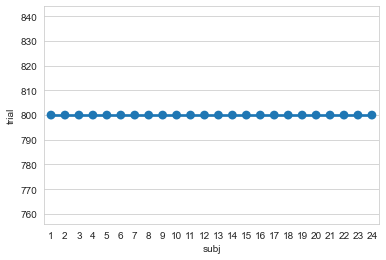

In [18]:
# all subjects have 800 trials (no trial missing)
d=data[data.practice==False].groupby(['subj']).agg({'trial':'count'})/(data.point.nunique())
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

#### Compute kernels, averaged for each participant

In [19]:
# exclude practice blocks and repeated blocks
data = data[data.practice==False]
data = data[~(data.block==9)] # one practice block per subject

In [20]:
# average coordinates per actor point true&false
averaged_data = data.groupby(['subj','actor','point','response']).agg({'x':'mean','y':'mean'}).reset_index()
positives = averaged_data.loc[averaged_data['response'] == True].reset_index()
negatives = averaged_data.loc[averaged_data['response'] == False].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','actor','point'],suffixes=['+','-'])

# compute difference coordinates per actor point
kernels['delta_x']=kernels['x+']-kernels['x-']
kernels['delta_y']=kernels['y+']-kernels['y-']
kernels.drop(['index+','index-','response+','response-','x+','y+','x-','y-'], axis=1, inplace=True)

# kernels then normalized for each subj/actor by dividing them 
# by the RMS of their values over all points 
kernels['square_delta_x'] = kernels['delta_x']**2
kernels['square_delta_y'] = kernels['delta_y']**2
for_norm = kernels.groupby(['subj','actor']).agg({'square_delta_x':'mean',
                                                  'square_delta_y':'mean'}).reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','actor'], suffixes=['','_mean'])
kernels['norm_delta_x'] = kernels['delta_x']/np.sqrt(kernels['square_delta_x_mean'])
kernels['norm_delta_y'] = kernels['delta_y']/np.sqrt(kernels['square_delta_y_mean'])
kernels.drop(['square_delta_x','square_delta_y','square_delta_x_mean','square_delta_y_mean'], axis=1, inplace=True)

In [21]:
# add neutral point coordinates
   
kernels['x_neutral'] = kernels.apply(lambda row: get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(row['actor']),
                                                                row['point'],'x'), axis=1)
kernels['y_neutral'] = kernels.apply(lambda row: get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(row['actor']),
                                                                row['point'],'y'), axis=1)


#### Save kernels

In [22]:
# save figs and kernels for all participants

subjects = kernels.subj.unique()

#index of the manipulated face points, listed in that order in stimulus info files
POINTS = [137,138,139,140,141,53,54,55,56,64,70,67,73,45,46,17,20,23, 52,51,35,32,29] 

gain=10 # for visualization only

for subj_index, subject in enumerate(subjects): #subjects in cols
    
    print('subject '+str(subject)+', ', end='')
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    for index, row in kernels[(kernels.subj==subject)&(kernels.actor==subject)].iterrows():
    
        # display neutral
        g1=plt.scatter(row['x_neutral'],row['y_neutral'], color='black', marker='^',zorder=2)
        ax.text(row['x_neutral'], row['y_neutral'], str(int(row['point'])), fontsize=7)
    
        # display displaced
        g2=plt.scatter(row['x_neutral']+gain*row['norm_delta_x'],
                       row['y_neutral']+gain*row['norm_delta_y'], color='red', marker='^', zorder=2)
        ax.text(row['x_neutral']+gain*row['norm_delta_x'],
                row['y_neutral']+gain*row['norm_delta_y'], str(int(row['point'])), fontsize=7)
    
        # display line between points
        plt.plot([row['x_neutral'],row['x_neutral']+gain*row['norm_delta_x']],
                 [row['y_neutral'], row['y_neutral']+gain*row['norm_delta_y']],
                 color='black', zorder=1)
            
    img = imread('../experiment/revcor-self/stims/Actor'+str(int(subject))+'/neutral.jpg')
    plt.imshow(img, zorder=0)
    plt.title('Subject '+str(subject))
    fig.savefig('./kernels/revcor-self/Subject'+str(subject)+'.png')
    plt.close(fig)
        
    # write actor-specific displacement to kernel file
    kernel_file = './kernels/revcor-self/Subject'+str(subject)+'.txt'
    with open(kernel_file, 'w+',newline='') as file:
        writer = csv.writer(file)            
        for point in POINTS:
            delta_x = kernels[(kernels.subj==subject)&(kernels.actor==subject)&(kernels.point==point)]['norm_delta_x'].iloc[0]
            delta_y = kernels[(kernels.subj==subject)&(kernels.actor==subject)&(kernels.point==point)]['norm_delta_y'].iloc[0]
            writer.writerow([delta_x])
            writer.writerow([delta_y])
        

subject 1, subject 2, subject 3, subject 4, subject 5, subject 6, subject 7, subject 8, subject 9, subject 10, subject 11, subject 12, subject 13, subject 14, subject 15, subject 16, subject 17, subject 18, subject 19, subject 20, subject 21, subject 22, subject 23, subject 24, 

### Questionnaire data

In [23]:
data_dir = 'data/questionnaire/'
data_files = glob.glob(data_dir+"results_Subj*.csv.gz")
print(len(data_files))
data = pd.DataFrame()
for data_file in data_files:
    participant_data = pd.read_csv(data_file, sep = ',', decimal='.', header='infer', compression='gzip')
    data = data.append(participant_data, ignore_index=True)

24


question_type
BESA     20
IPIP     32
TAS20    20
Name: question, dtype: int64


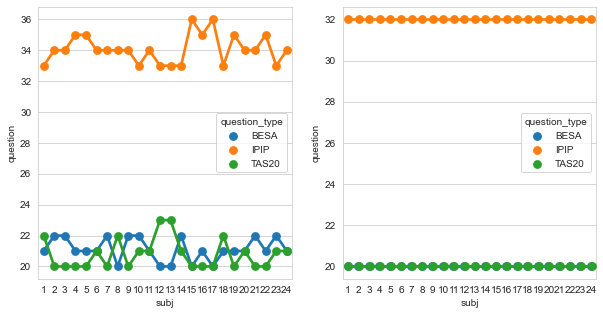

In [24]:
# 72 unique questions, but participants answered also 4 random training questions (first 4 trials), amounting to 76
print(data.groupby(['question_type'])['question'].nunique())
fig = plt.figure(figsize=(10,5));
plt.subplot(121)
sns.pointplot(data=data.groupby(['subj', 'question_type'])['question'].count().reset_index(), 
              x='subj',
              y='question',
             hue='question_type')
plt.subplot(122)
ax=sns.pointplot(data=data[data.trial > 3].groupby(['subj', 'question_type'])['question'].count().reset_index(), 
              x='subj',
              y='question',
             hue='question_type', 
                 dodge=True)

In [25]:
# remove training trials
data = data[data.trial > 3]

#### Toronto Alexithymia Scale TAS20

We measured participant's alexithymia using the French version of the Toronto Alexithymia Scale (TAS-20). The TAS-20 is a self-report scale composed of 20 items measuring a respondent's difficulty to identify emotions (5 items, e.g. *When I am upset, I don’t know if I am sad, frightened, or angry.*), describe emotions (7 items, e.g. *It is difficult for me to find the right
words for my feelings*) emotions, as well as their tendency to focus their attention on 'external', non-psychological things (8 items, e.g. *I prefer talking to people about their daily activities rather than their
feelings*). All items are rated using a 5-point Likert scale anchored by 1: *strongly disagree* and 5: *strongly agree*; and 5 items (items 4, 5, 10, 18 and 19) were reverse-coded. The total alexithymia score is the sum of responses to all 20 items, with scores greater than 61 generally taken as indicating alexithymia.

In [26]:
def aggregate_score_with_key(x, keys):
    score = 0
    for question_nb,scale in keys.items():
        response = np.array(x[x.question_nb==question_nb]['response'])[0]
        if scale == -1: 
            response = 6-response
        score += response
    return score

In [27]:
difficulty_describing_feelings={2:1,#J'ai souvent du mal à trouver les mots qui correspondent bien à mes sentiments
                                4:-1,#La plupart du temps, j'arrive facilement à décrire mes sentiments
                                11:1,#Je trouve généralement difficile de décrire mes sentiments sur les gens
                                12:1,#On me demande souvent de décrire davantage ce que je ressens
                                17:1} #Il m'est difficile de révéler mes sentiments intimes même à des amis très proches
                               
difficulty_identifying_feelings={1:1,#Souvent, je ne vois pas très clair dans mes sentiments
                                 3:1,#J'éprouve parfois des sensations physiques que même les médecins ne comprennent pas
                                 6:1,#Souvent, quand je suis bouleversé(e), je ne sais pas si je suis triste, effrayé(e), ou en colère
                                 7:1,#Je suis souvent intrigué(e) par certaines sensations que je ressens au niveau de mon corps
                                 9:1,#J'ai souvent des sentiments que je ne suis pas capable d'identifier
                                 13:1,#Je ne sais pas ce qui se passe à l'intérieur de moi
                                 14:1}#Bien souvent, je ne sais pas pourquoi je suis en colère

externally_oriented_thinking={5:-1,#Je préfère généralement analyser les problèmes plutôt que de me contenter de les décrire
                              8:1,#La plupart du temps, je préfère laisser les choses se produire, plutôt que de comprendre pourquoi elles sont arrivées
                              10:-1,#Je pense qu'être conscient de ses émotions est essentiel
                              15:1,#Je préfère parler aux gens de leurs activités quotidiennes plutôt que de leurs sentiments
                              16:1,#Je préfère regarder des émissions de variétés et de divertissement plutôt que des films psychologiques
                              18:-1,#Je peux me sentir proche de quelqu'un même pendant les moments de silence
                              19:-1,#Je trouve utile d'analyser mes sentiments pour résoudre mes problèmes personnels
                              20:1}#Rechercher le sens caché d'un film ou d'une pièce de théâtre, ça perturbe le plaisir qu'ils procurent


tas_difficulty_describing_feelings = data[data.question_type=='TAS20'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                                                    difficulty_describing_feelings))
tas_difficulty_identifying_feelings = data[data.question_type=='TAS20'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                                                    difficulty_identifying_feelings))
tas_externally_oriented_thinking = data[data.question_type=='TAS20'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                                                    externally_oriented_thinking))


In [28]:
data_tas = pd.concat([tas_difficulty_describing_feelings,
           tas_difficulty_identifying_feelings,
           tas_externally_oriented_thinking], axis=1)
data_tas.columns=['DDF',
                  'DIF',
                  'EOT']
data_tas['TAS20'] = data_tas['DDF']+\
                  data_tas['DIF']+\
                  data_tas['EOT']

M=48.71, SD=10.14


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


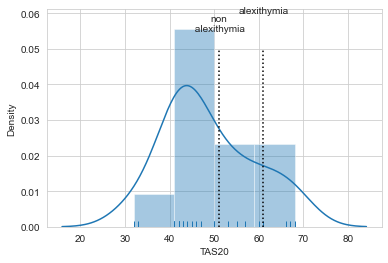

In [29]:
sns.distplot(data_tas['TAS20'],
            rug=True)
plt.plot([51,51],[0,0.05],'k:')
_=plt.text(51,0.055,'non\n alexithymia',horizontalalignment='center')
plt.plot([61,61],[0,0.05],'k:')
_=plt.text(61,0.06,'alexithymia',horizontalalignment='center')
print("M=%.2f, SD=%.2f"%(data_tas['TAS20'].mean(),
                    data_tas['TAS20'].std()))

Mean TAS20 = 48.71 (SD=10.14), N=3 above 61 cutoff, N=4 borderline

In [30]:
data_tas[data_tas.TAS20>61]

,DDF,DIF,EOT,TAS20
subj,,,,
3,17,22,29,68
15,19,30,18,67
22,18,32,16,66


#### Basic Empathy Scale in Adults (BESA)

We measured participant's trait empathy using the French version of the Basic Empathy Scale in Adults (BES-A). The BES-A is self-report scale composed of 20 items measuring a respondent's cognitive empathy (9 items, e.g. *I have trouble figuring out when my friends are happy*) and affective empathy (11 items, e.g. *I get caught up in other people’s feeling easily*) empathy. All items are rated using a 5-point Likert scale, 7 of them reverse-coded. Total empathy score ranges from 20 (deficit in empathy) to 100 (high level of empathy). 

In [31]:
affective_empathy={21:-1,#Généralement, les émotions de mes amis(ies) ne m'affectent pas beaucoup
           22:1,#Après avoir été avec un(e) ami(e) qui est triste, je me sens généralement triste
           24:1,#Je peux être effrayé(e) par un bon film d'horreur
           25:1,#Je m'imprègne facilement des émotions des autres
           27:-1,#Je ne suis pas souvent triste quand je vois une personne pleurer
           28:-1,#Les sentiments des autres ne me tracassent pas du tout 	
           31:1,#Souvent, je me sens triste quand je regarde des choses ou des films tristes
           33:-1, #Voir une personne se mettre en colère n'a généralement aucun effet sur moi
           35:1,#J'ai tendance à me sentir apeuré(ée) quand je suis avec des amis(ies) qui sont effrayés(ées)
           37:1,#Je suis souvent happé(e) par les sentiments de mes amis(ies)
           38:-1}#Je ressens rarement quelque chose face à la tristesse de mes amis(ies)

cognitive_empathy={23:1,#Je peux généralement comprendre le bonheur d'un(e) ami(e) lorsque quelque chose marche bien pour lui/elle
         26:1,#J'ai du mal à savoir quand mes amis(ies) ont peur
         29:1,#Quand quelqu'un a la sensation d'être au plus bas, je peux généralement comprendre ce qu'il/elle ressent
         30:1,#Généralement, je sais me rendre compte quand mes amis(ies) sont effrayés(ées)
         32:1,#Souvent, j'arrive à comprendre comment les gens se sentent avant même qu'ils ne me l'aient dit
         34:1,#Habituellement, j'arrive à savoir quand les gens sont joyeux
         36:1,#Généralement, je me rends vite compte quand un(e) ami(e) est furieux(se)
         39:-1,#Je ne suis généralement pas attentif(ve) aux sentiments de mes amis(ies)  
         40:-1}#J'ai du mal à comprendre quand mes amis(ies) sont heureux(ses)

besa_affective = data[data.question_type=='BESA'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                                                    affective_empathy))
besa_cognitive = data[data.question_type=='BESA'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                                                    cognitive_empathy))


In [32]:
data_besa = pd.concat([besa_affective,
           besa_cognitive], axis=1)
data_besa.columns=['AFF',
                  'COG']
data_besa['BESA'] = data_besa['AFF']+ data_besa['COG']

M=72.38, SD=8.86


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


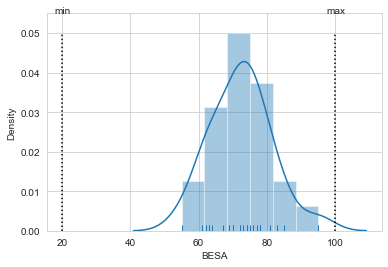

In [33]:
sns.distplot(data_besa['BESA'],
            rug=True)
plt.plot([20,20],[0,0.05],'k:')
_=plt.text(20,0.055,'min',horizontalalignment='center')
plt.plot([100,100],[0,0.05],'k:')
_=plt.text(100,0.055,'max',horizontalalignment='center')
print("M=%.2f, SD=%.2f"%(data_besa['BESA'].mean(),
                    data_besa['BESA'].std()))

BESA: mean = 72.4 (SD=8.9)

#### Interpersonal circumplexe (IPIP-PIC)

Participants’ scores on a given octant are computed by averaging together the four items for a given octant. An individual’s dimensional score of dominance and warmth can be computed using the geometric formula (Wiggins, 1995):
Dominance Dimension = (.3) $\Sigma Z_i \sin \theta_i$, Warmth Dimension = (.3)  $\Sigma Z_i \cos \theta_i$
where $Z_i$ represents the standardized score of the $i^{th}$ octant and $\theta_i$ is the angle of the $i^{th}$ octant.

In [34]:
# Assured−Dominant
PA={46:1,#J'aime être au centre de l'attention  
    54:1,#Je parle tout le temps 
    62:1,#J'ai tendance à parler fort 
    70:1}#J'ai besoin d'attention 
# Arrogant−Calculating
BC={47:1,#Je ne suis pas tendre avec les autres
    55:1,#Je contredis tout le temps mes interlocuteurs 
    63:1,#Je rétorque facilement aux gens de façon agressive 
    71:1}#J'ai la langue bien pendue
# Cold−Hearted
DE={48:1,#Je trouve que chacun doit savoir se défendre tout seul 
    56:1,#Les histoires sentimentales, très peu pour moi   
    64:1,#Je ne réfléchis pas trop avant d'agir ou de parler  
    72:1}#Les problèmes de autres, ça ne m'intéresse pas 
#Aloof−Introverted
FG={41:1,#Je suis réservé devant des gens que je ne connais pas   
    49:1,#Je ne donne jamais de détails sur ma vie privée     
    57:1,#Je ne suis pas très causant  
    65:1}#Je n'ai généralement pas grand chose à dire  
#Unassured−Submissive
HI={42:1,#Je parle généralement doucement 
    50:1,#Je laisse toujours les autres finir ce qu'ils sont en train de dire
    58:1,#Je ne suis pas du genre à me vanter  
    66:1}#J'ai horreur d'être le centre de l'attention 
#Unassuming−Ingenuous
JK={43:1,#Je peux tolèrer beaucoup de la part des autres
    51:1,#Je prends les choses telles qu'elles sont
    59:1,#Je fais passer les autres avant moi
    67:1}#Je n'exagère jamais ce que je raconte  
# Warm−Agreeable
LM={44:1,#Je m'intéresse aux autres
    52:1,#Je rassure souvent les autres  
    60:1,#Je fais attention au bien-être des gens que je cotoie 
    68:1}#Je m'entends bien avec les autres  
#Gregarious−Extraverted
NO={45:1,#Je suis à l'aise quand il y a du monde 
    53:1,#C'est souvent moi qui initie les conversations 
    61:1,#Quand il y a une fête, je parle toujours à plein de gens différents
    69:1}#J'aime les fêtes où il y a plein de monde  

IPC_PA = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            PA)/4)
IPC_BC = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            BC)/4)
IPC_DE = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            DE)/4)
IPC_FG = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            FG)/4)
IPC_HI = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            HI)/4)
IPC_JK = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            JK)/4)
IPC_LM = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            LM)/4)
IPC_NO = data[data.question_type=='IPIP'].groupby(['subj']).apply(lambda x: aggregate_score_with_key(x,
                                                                            NO)/4)



In [35]:
import math
data_ipc = pd.concat([IPC_PA,IPC_BC,IPC_DE,IPC_FG,IPC_HI,IPC_JK,IPC_LM,IPC_NO],
                     axis=1)
data_ipc.columns=['PA','BC','DE','FG','HI','JK','LM','NO']

# z-score each octant score
for octant in data_ipc.columns:
    data_ipc[octant]=(data_ipc[octant]-data_ipc[octant].mean())/data_ipc[octant].std()

# compute warmth/dominance
angles = {'PA':np.pi/2,
          'BC':3*np.pi/4,
          'DE':np.pi,
          'FG':5*np.pi/4,
          'HI':3*np.pi/2,
          'JK':7*np.pi/4,
          'LM':0,
          'NO':np.pi/4}

# warmth & dominance
data_ipc['warmth'] = 0
data_ipc['dominance'] = 0
for octant,angle in angles.items(): 
    data_ipc['warmth'] += data_ipc[octant]*math.cos(angle)
    data_ipc['dominance'] += data_ipc[octant]*math.sin(angle)


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for 

Warmth: M=0.00, SD=2.23
Dominance: M=0.00, SD=3.72


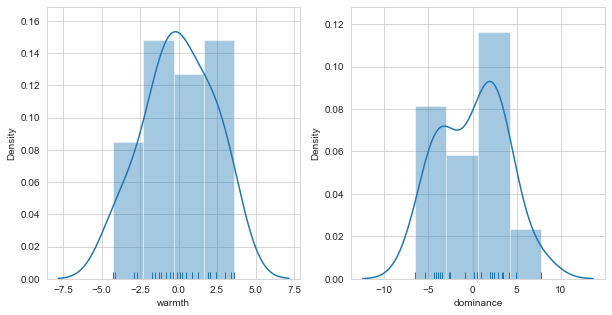

In [36]:
fig = plt.figure(figsize=(10,5));
plt.subplot(121)
sns.distplot(data_ipc['warmth'],rug=True)
print("Warmth: M=%.2f, SD=%.2f"%(data_ipc['warmth'].mean(),
                    data_ipc['warmth'].std()))
plt.subplot(122)
sns.distplot(data_ipc['dominance'],rug=True)
print("Dominance: M=%.2f, SD=%.2f"%(data_ipc['dominance'].mean(),
                    data_ipc['dominance'].std()))



In [37]:
questions = pd.concat([data_tas,
                       data_besa, 
                       data_ipc[['warmth','dominance']]],axis=1).reset_index()


In [38]:
measures = questions.columns[1::]
from itertools import combinations

for pair in combinations(measures, 2):
    a= st.linregress(list(questions[pair[0]]),
                list(questions[pair[1]]))
    print("%s vs %s: R = %.3f p = %.4f %s"%(pair[0],
                                             pair[1],
                                             a.rvalue,
                                             a.pvalue,
                                             '(*)' if a.pvalue < 0.05 else ''))
    

DDF vs DIF: R = 0.451 p = 0.0268 (*)
DDF vs EOT: R = -0.115 p = 0.5933 
DDF vs TAS20: R = 0.592 p = 0.0023 (*)
DDF vs AFF: R = -0.068 p = 0.7516 
DDF vs COG: R = -0.124 p = 0.5649 
DDF vs BESA: R = -0.110 p = 0.6076 
DDF vs warmth: R = -0.226 p = 0.2872 
DDF vs dominance: R = -0.341 p = 0.1031 
DIF vs EOT: R = 0.147 p = 0.4924 
DIF vs TAS20: R = 0.834 p = 0.0000 (*)
DIF vs AFF: R = 0.189 p = 0.3769 
DIF vs COG: R = 0.021 p = 0.9240 
DIF vs BESA: R = 0.176 p = 0.4111 
DIF vs warmth: R = -0.119 p = 0.5790 
DIF vs dominance: R = 0.284 p = 0.1786 
EOT vs TAS20: R = 0.554 p = 0.0050 (*)
EOT vs AFF: R = -0.176 p = 0.4099 
EOT vs COG: R = -0.353 p = 0.0905 
EOT vs BESA: R = -0.299 p = 0.1559 
EOT vs warmth: R = -0.042 p = 0.8453 
EOT vs dominance: R = 0.495 p = 0.0139 (*)
TAS20 vs AFF: R = -0.007 p = 0.9750 
TAS20 vs COG: R = -0.217 p = 0.3083 
TAS20 vs BESA: R = -0.094 p = 0.6636 
TAS20 vs warmth: R = -0.179 p = 0.4028 
TAS20 vs dominance: R = 0.287 p = 0.1735 
AFF vs COG: R = 0.070 p = 0.74

The only significant correlations are internal: AFF & COG vs BESA; DDT, DIT, EOT vs TAS20. The only exception is dominance vs EOT (R = 0.495 p = 0.0139), but not dominance vs the overall TAS20 (R = 0.287 p = 0.1735). 

In [39]:
questions.to_csv('data/questionnaire.csv')

## Results

### Facial configurations over the group

N=24 participants (M=23.8yo; female: 12) participated in a series of tasks involving producing a posed smile of affiliation, observing pairs of manipulated facial photographs (in one session, their own face; in another, that of unknown others) to report which expression in each pair is most affiliative and, finally, a validation task in which they rated the intensity of affiliation in manipulated vs non-manipulated photographs. 

For each participant, this procedure allowed computing three types of psychophysical kernels, which described (1) the specific displacement of facial features involved to generate the participant's smiling face from their resting face ([Production](#prod)), (2) what displacement should be applied to the participant's own resting face in order to increase the probability that they select the resulting face as affiliative ([Self](#self)) and (3) what displacement should be applied to an unknown other's face in order to increase that same probability ([Other](#other)). All three types of kernels had the same format, and consisted of the (x,y) coordinates of the displacement vectors for each of 23 facial landmarks (left eye: 2 points; left eyebrow: 3; right eye: 2; right eyebrow: 3; nose: 4; forehead: 5; mouth: 4), in normalized, arbitrary units of displacement.


#### Other perception kernels
<a id='other'></a>

To test for the statistical significance of kernel deviation at each landmark over the group (N=24), we projected each landmark’s (x,y)-deviation (in each of the N=24 individual kernels) on that landmark’s averaged direction of deviation over the group, and tested whether that projection statistically differed from zero. 

In [40]:
# load actor kernels (average of two actors)
SUBJECTS=range(1,25)
subjects=[]
points = []
for subj in SUBJECTS:
    for point in POINTS: 
        subjects.append(int(subj))
        points.append(point)
kernels=pd.DataFrame.from_dict({'subj':subjects,'point':points})

kernels['delta_x'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-actors/Subject%d_Average.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)
kernels['delta_y'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-actors/Subject%d_Average.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)


In [41]:
# compute dot product of each subject's displacement vector, with the group average displacement vector

group_mean = kernels.groupby(['point']).agg({'delta_x':'mean','delta_y':'mean'})
kernels = pd.merge(kernels, group_mean, 
                   on=['point'], suffixes=['','_mean'])             
kernels['dot_product'] = kernels.apply(lambda row: np.dot([row['delta_x'],row['delta_y']],
                                                          [row['delta_x_mean'],row['delta_y_mean']]), axis=1)


In [42]:
# compute t-tests and confidence intervals on mean delta coordinates for each point

def ttest(x):
    return "t = %6.3f p = %6.4f" %st.ttest_1samp(list(x), 0)

kernel_stats = kernels.groupby(['point']).agg({'delta_x':['mean',st.sem,ttest],
                                           'delta_y':['mean',st.sem,ttest],
                                           'dot_product':['mean',st.sem,ttest],    
                                           'subj':'count'}).reset_index()
# make column names on one level
kernel_stats.columns = ['_'.join(tup).rstrip('_') for tup in kernel_stats.columns.values]

kernel_stats['delta_x_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[0],axis=1)
kernel_stats['delta_x_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[1],axis=1)
kernel_stats['delta_y_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[0],axis=1)
kernel_stats['delta_y_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[1],axis=1) 
kernel_stats['dot_product_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['dot_product_mean'], 
                                                                   scale=row['dot_product_sem'])[0],axis=1)
kernel_stats['dot_product_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['dot_product_mean'], 
                                                                   scale=row['dot_product_sem'])[1],axis=1)

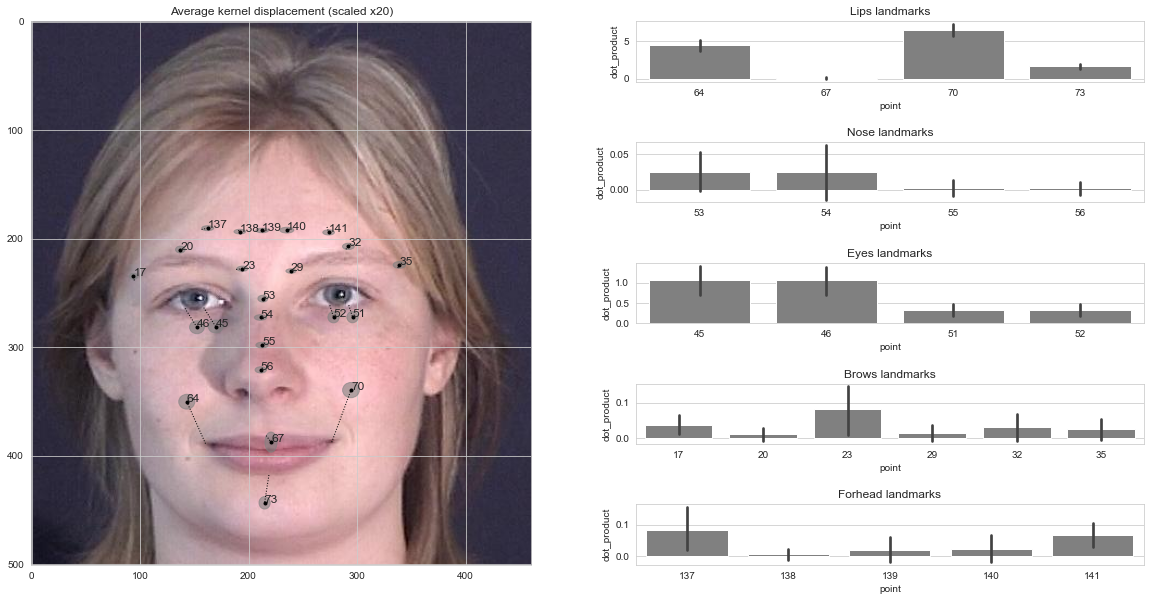

In [43]:
# visualize mean displacements on one actor (with circles marking confidence intervals on dot-product)
# and histograms on dot-product displacements for each landmark point

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# fetch neutral landmark positions for one actor
actor = 1
kernel_stats['x_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-actors/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'x'), axis=1)
kernel_stats['y_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-actors/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'y'), axis=1)

fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1)
ax = fig.add_subplot(121)
scale = 20 #multiply kernel amplitude

for index, row in kernel_stats.iterrows():
    
    # display neutral
    #g1=plt.scatter(row['x_neutral'],row['y_neutral'], color='black', marker='.',zorder=3)
    #ax.text(row['x_neutral_mean'], row['y_neutral_mean'], str(int(row['point'])), fontsize=12)
    
    # display displaced
    g2=plt.scatter(row['x_neutral']+scale*row['delta_x_mean'],
                   row['y_neutral']+scale*row['delta_y_mean'], color='black', marker='.', zorder=3)
    ax.text(row['x_neutral']+scale*row['delta_x_mean'], 
            row['y_neutral']+scale*row['delta_y_mean'], str(int(row['point'])), fontsize=12)
    
    # display line between points
    plt.plot([row['x_neutral'],
              row['x_neutral']+scale*row['delta_x_mean']],
             [row['y_neutral'], 
              row['y_neutral']+scale*row['delta_y_mean']],
             color='black',linestyle=':',linewidth=1, zorder=2)
    
    # draw confidence interval as ellipse
    conf = Ellipse((row['x_neutral'] + scale*row['delta_x_mean'],
                    row['y_neutral'] + scale*row['delta_y_mean']),
                   width = scale*(row['delta_x_sup']-row['delta_x_inf']),
                   height = scale*(row['delta_y_sup']-row['delta_y_inf']),
                   facecolor = 'grey',
                   edgecolor = 'grey',
                   alpha = 0.6, 
                   zorder = 2)
    #note: to have ellipses with different x & y confidence intervals, use alternatively: 
    #width = scale*(row['delta_x_sup']-row['delta_x_inf']),height = scale*(row['delta_y_sup']-row['delta_y_inf']),
    # to have circles marking confidence intervals on dot-product, use:
    # width = scale*(row['dot_product_sup']-row['dot_product_inf']),height = scale*(row['dot_product_sup']-row['dot_product_inf']),
    
    ax.add_patch(conf)
   
img = imread('../experiment/revcor-actors/stims/Actor'+str(int(actor))+'/neutral.jpg')
plt.imshow(img, zorder=0)
plt.title('Average kernel displacement (scaled x%d)'%scale)

# histograms on total displacement
for index,region in enumerate(POINT_GROUPS.keys()): 
    
    ax = fig.add_subplot(5,2,2*index+2)
    sns.barplot(ax=ax,
                x = 'point', 
                y='dot_product',
                units='subj',
                ci=95,
                data=kernels[kernels.point.isin(POINT_GROUPS[region])],
            color='grey')
    plt.title(str(region).capitalize()+' landmarks')
    ax.set_ylabel = "Displacement"
    ax.set_xlabel = "Landmark"

plt.savefig('./pics/other-kernel.jpg', format='jpg', dpi=600, transparent=True)

In [44]:
# print statistics per landmarks
n_points = kernel_stats.point.nunique()
alpha = 0.05 / n_points
for index,region in enumerate(POINT_GROUPS.keys()): 
    print("%s points:"%region)
    for index, row in kernel_stats[kernel_stats.point.isin(POINT_GROUPS[region])].iterrows(): 
        print('%d: %s'%(row['point'],row['dot_product_ttest']), end ='')
        if float(row['dot_product_ttest'].split("=")[-1])<alpha: 
            print(' (*) ')
        else: 
            print()

Lips points:
64: t = 11.635 p = 0.0000 (*) 
67: t =  1.845 p = 0.0779
70: t = 14.882 p = 0.0000 (*) 
73: t =  8.958 p = 0.0000 (*) 
Nose points:
53: t =  1.730 p = 0.0970
54: t =  1.263 p = 0.2193
55: t =  0.357 p = 0.7245
56: t =  0.377 p = 0.7093
Eyes points:
45: t =  5.813 p = 0.0000 (*) 
46: t =  5.813 p = 0.0000 (*) 
51: t =  4.213 p = 0.0003 (*) 
52: t =  4.213 p = 0.0003 (*) 
Brows points:
17: t =  2.732 p = 0.0119
20: t =  1.101 p = 0.2824
23: t =  2.334 p = 0.0287
29: t =  1.164 p = 0.2564
32: t =  1.553 p = 0.1341
35: t =  1.654 p = 0.1118
Forhead points:
137: t =  2.289 p = 0.0316
138: t =  0.899 p = 0.3778
139: t =  1.031 p = 0.3131
140: t =  1.072 p = 0.2950
141: t =  3.452 p = 0.0022


#### Self perception kernels
<a id='self'></a>

To test for the statistical significance of kernel deviation at each landmark over the group (N=24), we projected each landmark’s (x,y)-deviation (in each of the N=24 individual kernels) on that landmark’s averaged direction of deviation over the group, and tested whether that projection statistically differed from zero. 

In [45]:
# load self kernels 
SUBJECTS=range(1,25)
subjects=[]
points = []
for subj in SUBJECTS:
    for point in POINTS: 
        subjects.append(int(subj))
        points.append(point)
kernels=pd.DataFrame.from_dict({'subj':subjects,'point':points})

kernels['delta_x'] = kernels.apply(lambda row:\
                                   #get_coordinate('./code sarra/Kernels_self/self_kernel_Subject%d.txt'%(row['subj']),
                                   get_coordinate('./kernels/revcor-self/Subject%d.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)
kernels['delta_y'] = kernels.apply(lambda row:\
                                   #get_coordinate('./code sarra/Kernels_self/self_kernel_Subject%d.txt'%(row['subj']),
                                   get_coordinate('./kernels/revcor-self/Subject%d.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)


In [46]:
# compute dot product of each subject's displacement vector, with the group average displacement vector

group_mean = kernels.groupby(['point']).agg({'delta_x':'mean','delta_y':'mean'})
kernels = pd.merge(kernels, group_mean, 
                   on=['point'], suffixes=['','_mean'])             
kernels['dot_product'] = kernels.apply(lambda row: np.dot([row['delta_x'],row['delta_y']],
                                                          [row['delta_x_mean'],row['delta_y_mean']]), axis=1)


In [47]:
# compute t-tests and confidence intervals on mean delta coordinates for each point

def ttest(x):
    return "t = %6.3f p = %6.4f" %st.ttest_1samp(list(x), 0)

kernel_stats = kernels.groupby(['point']).agg({'delta_x':['mean',st.sem,ttest],
                                           'delta_y':['mean',st.sem,ttest],
                                           'dot_product':['mean',st.sem,ttest],    
                                           'subj':'count'}).reset_index()
# make column names on one level
kernel_stats.columns = ['_'.join(tup).rstrip('_') for tup in kernel_stats.columns.values]

kernel_stats['delta_x_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[0],axis=1)
kernel_stats['delta_x_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[1],axis=1)
kernel_stats['delta_y_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[0],axis=1)
kernel_stats['delta_y_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[1],axis=1) 
kernel_stats['dot_product_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['dot_product_mean'], 
                                                                   scale=row['dot_product_sem'])[0],axis=1)
kernel_stats['dot_product_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['dot_product_mean'], 
                                                                   scale=row['dot_product_sem'])[1],axis=1)

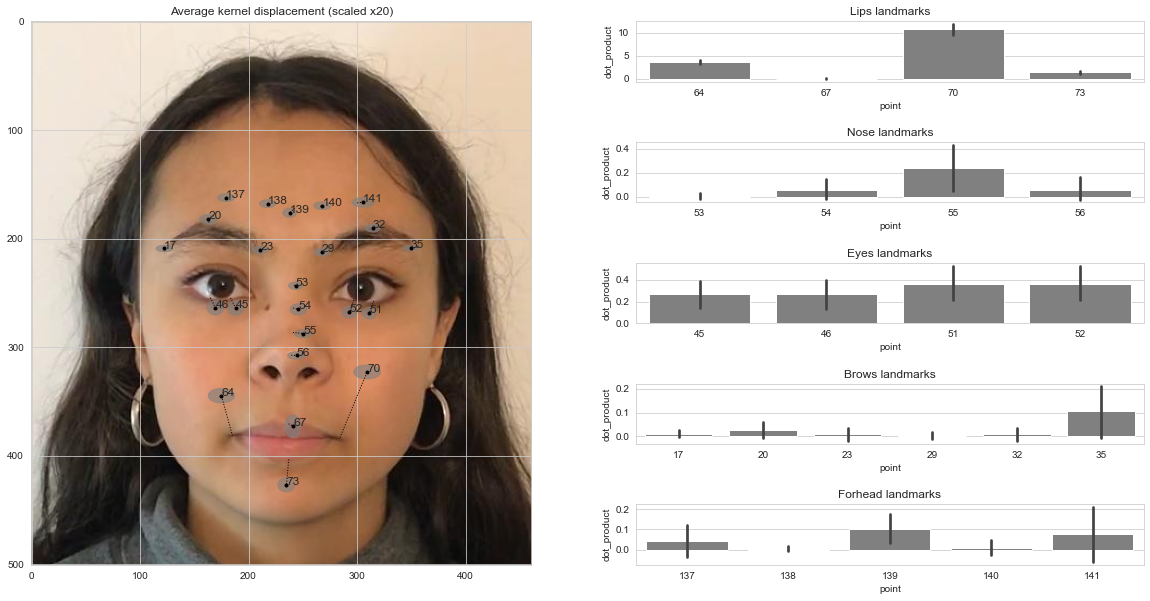

In [48]:
# visualize mean displacements on one actor (with circles marking confidence intervals on dot-product)
# and histograms on dot-product displacements for each landmark point

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# fetch neutral landmark positions for one actor
actor = 9
kernel_stats['x_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'x'), axis=1)
kernel_stats['y_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'y'), axis=1)

fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1)
ax = fig.add_subplot(121)
scale = 20 #multiply kernel amplitude

for index, row in kernel_stats.iterrows():
    
    # display neutral
    #g1=plt.scatter(row['x_neutral'],row['y_neutral'], color='black', marker='.',zorder=3)
    #ax.text(row['x_neutral_mean'], row['y_neutral_mean'], str(int(row['point'])), fontsize=12)
    
    # display displaced
    g2=plt.scatter(row['x_neutral']+scale*row['delta_x_mean'],
                   row['y_neutral']+scale*row['delta_y_mean'], color='black', marker='.', zorder=3)
    ax.text(row['x_neutral']+scale*row['delta_x_mean'], 
            row['y_neutral']+scale*row['delta_y_mean'], str(int(row['point'])), fontsize=12)
    
    # display line between points
    plt.plot([row['x_neutral'],
              row['x_neutral']+scale*row['delta_x_mean']],
             [row['y_neutral'], 
              row['y_neutral']+scale*row['delta_y_mean']],
             color='black',linestyle=':',linewidth=1, zorder=2)
    
    # draw confidence interval as ellipse
    conf = Ellipse((row['x_neutral'] + scale*row['delta_x_mean'],
                    row['y_neutral'] + scale*row['delta_y_mean']),
                   width = scale*(row['delta_x_sup']-row['delta_x_inf']),
                   height = scale*(row['delta_y_sup']-row['delta_y_inf']),
                   facecolor = 'grey',
                   edgecolor = 'grey',
                   alpha = 0.6, 
                   zorder = 2)
    #note: to have ellipses with different x & y confidence intervals, use alternatively: 
    # width = scale*(row['delta_x_sup']-row['delta_x_inf']),height = scale*(row['delta_y_sup']-row['delta_y_inf']),
    # to have circles marking confidence intervals on dot-product, use:
    # width = scale*(row['dot_product_sup']-row['dot_product_inf']),height = scale*(row['dot_product_sup']-row['dot_product_inf']),
    ax.add_patch(conf)
   
img = imread('../experiment/revcor-self/stims/Actor'+str(int(actor))+'/neutral.jpg')
plt.imshow(img, zorder=0)
plt.title('Average kernel displacement (scaled x%d)'%scale)

# histograms on total displacement
for index,region in enumerate(POINT_GROUPS.keys()): 
    
    ax = fig.add_subplot(5,2,2*index+2)
    sns.barplot(ax=ax,
                x = 'point', 
                y='dot_product',
                units='subj',
                ci=95,
                data=kernels[kernels.point.isin(POINT_GROUPS[region])],
            color='grey')
    plt.title(str(region).capitalize()+' landmarks')
    ax.set_ylabel = "Displacement"
    ax.set_xlabel = "Landmark"
    
    
plt.savefig('./pics/self-kernel.jpg', format='jpg', dpi=600, transparent=True)


In [49]:
# print statistics per landmarks
n_points = kernel_stats.point.nunique()
alpha = 0.05 / n_points
for index,region in enumerate(POINT_GROUPS.keys()): 
    print("%s points:"%region)
    for index, row in kernel_stats[kernel_stats.point.isin(POINT_GROUPS[region])].iterrows(): 
        print('%d: %s'%(row['point'],row['dot_product_ttest']), end ='')
        if float(row['dot_product_ttest'].split("=")[-1])<alpha: 
            print(' (*) ')
        else: 
            print()
        

Lips points:
64: t = 12.434 p = 0.0000 (*) 
67: t =  1.280 p = 0.2133
70: t = 16.615 p = 0.0000 (*) 
73: t =  7.630 p = 0.0000 (*) 
Nose points:
53: t =  0.606 p = 0.5502
54: t =  1.404 p = 0.1736
55: t =  2.420 p = 0.0238
56: t =  1.218 p = 0.2356
Eyes points:
45: t =  4.030 p = 0.0005 (*) 
46: t =  4.030 p = 0.0005 (*) 
51: t =  4.386 p = 0.0002 (*) 
52: t =  4.386 p = 0.0002 (*) 
Brows points:
17: t =  1.290 p = 0.2099
20: t =  1.423 p = 0.1681
23: t =  0.498 p = 0.6229
29: t =  0.426 p = 0.6737
32: t =  0.547 p = 0.5900
35: t =  1.851 p = 0.0770
Forhead points:
137: t =  1.126 p = 0.2716
138: t =  0.644 p = 0.5262
139: t =  2.663 p = 0.0139
140: t =  0.487 p = 0.6309
141: t =  1.072 p = 0.2947


Despite being measured with different stimuli, one week apart, [self](#self) and [other](#other) perception kernels were remarkably similar over the group. Both had significant displacements (at the $\alpha$=0.002 level, Bonferroni-corrected over 23 landmarks) at the same 3 lip points (*right corner 64*: self: t(23)=12.43, p<.0001; other: t(23)=12.43, p<.0001 -- *left corner 70*: self: t(23)=16.62, p<.0001; other: t(23)=14.88, p<.0001 -- *lower lip 73*: self: t(23)= 7.63, p< .0001; other: t(23)=8.96, p<.0001), and over the 4 eye points (*right lower lid 45: self : t(23)=4.03, p=.0005; other: t(23)=5.83, p<.0001-- *right lower lid 46*: self: t(23)=4.03, p=.0005; other:t(23)=5.83, p<.0001 -- *left lower lid 51*: self: t(23)=4.38, p=.0002; other: t(23)=4.21,p=.0003 -- *left lower lid 52*: self: t(23)=4.38, p=.0002; other: t(23)=4.21,p=.0003). 

#### Production kernels
<a id='prod'></a>

To test for the statistical significance of kernel deviation at each landmark over the group (N=24), we projected each landmark’s (x,y)-deviation (in each of the N=24 individual kernels) on that landmark’s averaged direction of deviation over the group, and tested whether that projection statistically differed from zero. 

In [50]:
# load self kernels 
SUBJECTS=range(1,25)
subjects=[]
points = []
for subj in SUBJECTS:
    for point in POINTS: 
        subjects.append(int(subj))
        points.append(point)
kernels=pd.DataFrame.from_dict({'subj':subjects,'point':points})

kernels['delta_x'] = kernels.apply(lambda row:\
                                   #get_coordinate('./code sarra/kernels_real_ali/real_kernel_Subject%d.txt'%(row['subj']),
                                   get_coordinate('./kernels/production/Subject%d.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)
kernels['delta_y'] = kernels.apply(lambda row:\
                                   #get_coordinate('./code sarra/kernels_real_ali/real_kernel_Subject%d.txt'%(row['subj']),
                                   get_coordinate('./kernels/production/Subject%d.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)


In [51]:
# compute dot product of each subject's displacement vector, with the group average displacement vector

group_mean = kernels.groupby(['point']).agg({'delta_x':'mean','delta_y':'mean'})
kernels = pd.merge(kernels, group_mean, 
                   on=['point'], suffixes=['','_mean'])             
kernels['dot_product'] = kernels.apply(lambda row: np.dot([row['delta_x'],row['delta_y']],
                                                          [row['delta_x_mean'],row['delta_y_mean']]), axis=1)


In [52]:
# compute t-tests and confidence intervals on mean delta coordinates for each point

def ttest(x):
    return "t = %6.3f p = %6.4f" %st.ttest_1samp(list(x), 0)

kernel_stats = kernels.groupby(['point']).agg({'delta_x':['mean',st.sem,ttest],
                                           'delta_y':['mean',st.sem,ttest],
                                           'dot_product':['mean',st.sem,ttest],    
                                           'subj':'count'}).reset_index()
# make column names on one level
kernel_stats.columns = ['_'.join(tup).rstrip('_') for tup in kernel_stats.columns.values]

kernel_stats['delta_x_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[0],axis=1)
kernel_stats['delta_x_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[1],axis=1)
kernel_stats['delta_y_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[0],axis=1)
kernel_stats['delta_y_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[1],axis=1) 
kernel_stats['dot_product_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['dot_product_mean'], 
                                                                   scale=row['dot_product_sem'])[0],axis=1)
kernel_stats['dot_product_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['dot_product_mean'], 
                                                                   scale=row['dot_product_sem'])[1],axis=1)

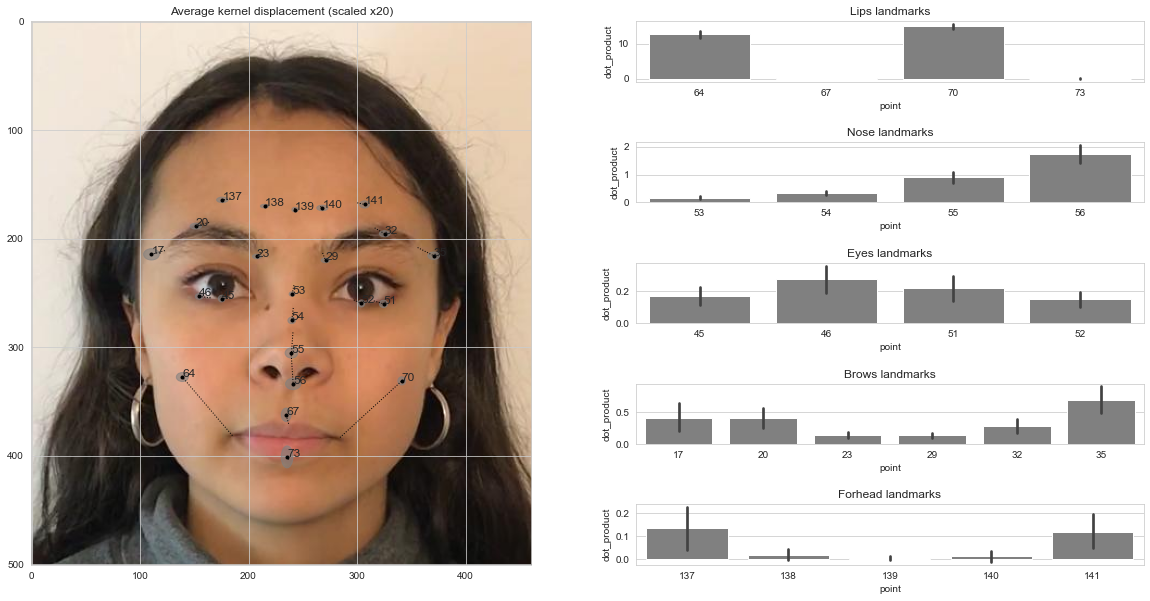

In [53]:
# visualize mean displacements on one actor (with circles marking confidence intervals on dot-product)
# and histograms on dot-product displacements for each landmark point

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# fetch neutral landmark positions for one actor
actor = 9
kernel_stats['x_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'x'), axis=1)
kernel_stats['y_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'y'), axis=1)

fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1)
ax = fig.add_subplot(121)
scale = 20 #multiply kernel amplitude

for index, row in kernel_stats.iterrows():
    
    # display neutral
    #g1=plt.scatter(row['x_neutral'],row['y_neutral'], color='black', marker='.',zorder=3)
    #ax.text(row['x_neutral_mean'], row['y_neutral_mean'], str(int(row['point'])), fontsize=12)
    
    # display displaced
    g2=plt.scatter(row['x_neutral']+scale*row['delta_x_mean'],
                   row['y_neutral']+scale*row['delta_y_mean'], color='black', marker='.', zorder=3)
    ax.text(row['x_neutral']+scale*row['delta_x_mean'], 
            row['y_neutral']+scale*row['delta_y_mean'], str(int(row['point'])), fontsize=12)
    
    # display line between points
    plt.plot([row['x_neutral'],
              row['x_neutral']+scale*row['delta_x_mean']],
             [row['y_neutral'], 
              row['y_neutral']+scale*row['delta_y_mean']],
             color='black',linestyle=':',linewidth=1, zorder=2)
    
    # draw confidence interval as ellipse
    conf = Ellipse((row['x_neutral'] + scale*row['delta_x_mean'],
                    row['y_neutral'] + scale*row['delta_y_mean']),
                   width = scale*(row['delta_x_sup']-row['delta_x_inf']),
                   height = scale*(row['delta_y_sup']-row['delta_y_inf']),
                   facecolor = 'grey',
                   edgecolor = 'grey',
                   alpha = 0.6, 
                   zorder = 2)
    #note: to have ellipses with different x & y confidence intervals, use alternatively: 
    #width = scale*(row['delta_x_sup']-row['delta_x_inf']),height = scale*(row['delta_y_sup']-row['delta_y_inf']),
    
    ax.add_patch(conf)
   
img = imread('../experiment/revcor-self/stims/Actor'+str(int(actor))+'/neutral.jpg')
plt.imshow(img, zorder=0)
plt.title('Average kernel displacement (scaled x%d)'%scale)

# histograms on total displacement
for index,region in enumerate(POINT_GROUPS.keys()): 
    
    ax = fig.add_subplot(5,2,2*index+2)
    sns.barplot(ax=ax,
                x = 'point', 
                y='dot_product',
                units='subj',
                ci=95,
                data=kernels[kernels.point.isin(POINT_GROUPS[region])],
            color='grey')
    plt.title(str(region).capitalize()+' landmarks')
    ax.set_ylabel = "Displacement"
    ax.set_xlabel = "Landmark"
    
plt.savefig('./pics/prod-kernel.jpg', format='jpg', dpi=600, transparent=True)



In [54]:
# print statistics per landmarks
n_points = kernel_stats.point.nunique()
alpha = 0.05 / n_points
for index,region in enumerate(POINT_GROUPS.keys()): 
    print("%s points:"%region)
    for index, row in kernel_stats[kernel_stats.point.isin(POINT_GROUPS[region])].iterrows(): 
        print('%d: %s'%(row['point'],row['dot_product_ttest']), end ='')
        if float(row['dot_product_ttest'].split("=")[-1])<alpha: 
            print(' (*) ')
        else: 
            print()

Lips points:
64: t = 26.550 p = 0.0000 (*) 
67: t =  2.869 p = 0.0087
70: t = 41.921 p = 0.0000 (*) 
73: t =  0.625 p = 0.5379
Nose points:
53: t =  8.107 p = 0.0000 (*) 
54: t =  7.909 p = 0.0000 (*) 
55: t =  8.392 p = 0.0000 (*) 
56: t = 10.182 p = 0.0000 (*) 
Eyes points:
45: t =  5.478 p = 0.0000 (*) 
46: t =  5.898 p = 0.0000 (*) 
51: t =  5.264 p = 0.0000 (*) 
52: t =  5.962 p = 0.0000 (*) 
Brows points:
17: t =  3.500 p = 0.0019 (*) 
20: t =  4.992 p = 0.0000 (*) 
23: t =  6.393 p = 0.0000 (*) 
29: t =  6.435 p = 0.0000 (*) 
32: t =  4.828 p = 0.0001 (*) 
35: t =  6.271 p = 0.0000 (*) 
Forhead points:
137: t =  2.834 p = 0.0094
138: t =  1.585 p = 0.1267
139: t =  1.553 p = 0.1340
140: t =  1.040 p = 0.3092
141: t =  2.951 p = 0.0072


Production kernels, which correspond to the participants' actual smiling behaviour, featured displacements at the same lip ( *right corner 64*: t(23)=26.55, p<.0001 -- *left corner 70*: t(23)=41.92, p<.0001) and eye locations (*right lower lid 45*: t(23)=5.48, p<.0001 -- *right lower lid 46*: t(23)=5.90, p<.0001 -- *left lower lid 51*: t(23)=5.26, p<.0001 -- *left lower lid 52*: t(23)=5.96, p<.0001) as the [self](#self) and [other](#other) perception kernels. In addition, production kernels also included significant displacements at a more varied set of landmarks in the nose  (landmarks 53,54,55,56; all ps<.0001) and brow regions (landmarks 17,20,23,29,32,35; all ps<.002). These latter changes likely reflect more global changes of facial configurations (e.g. a general downward change of face inclination) than what can be explored by the reverse-correlation stimuli used in the two perception tasks.

#### Visualize all three kernels on the same face

In [55]:
# load all kernels 
SUBJECTS=range(1,25)
TASKS = ['self','actors','prod']
subjects=[]
points = []
tasks = []
for subj in SUBJECTS:
    for point in POINTS: 
        for task in TASKS:
            subjects.append(int(subj))
            points.append(point)
            tasks.append(task)
kernels=pd.DataFrame.from_dict({'subj':subjects,
                                'point':points, 
                                'task':tasks})

kernels.loc[kernels['task']=='self',
            'delta_x'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-self/Subject%d.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)
kernels.loc[kernels['task']=='self',
            'delta_y'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-self/Subject%d.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)
kernels.loc[kernels['task']=='prod',
            'delta_x'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/production/Subject%d.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)
kernels.loc[kernels['task']=='prod',
            'delta_y'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/production/Subject%d.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)

kernels.loc[kernels['task']=='actors',
            'delta_x'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-actors/Subject%d_Average.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)

kernels.loc[kernels['task']=='actors',
            'delta_y'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-actors/Subject%d_Average.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)


In [56]:
# compute confidence intervals on mean delta coordinates for each point

kernel_stats = kernels.groupby(['point','task']).agg({'delta_x':['mean',st.sem],
                                           'delta_y':['mean',st.sem],    
                                           'subj':'count'}).reset_index()
# make column names on one level
kernel_stats.columns = ['_'.join(tup).rstrip('_') for tup in kernel_stats.columns.values]

kernel_stats['delta_x_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[0],axis=1)
kernel_stats['delta_x_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_x_mean'], 
                                                                   scale=row['delta_x_sem'])[1],axis=1)
kernel_stats['delta_y_inf'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[0],axis=1)
kernel_stats['delta_y_sup'] = kernel_stats.apply(lambda row: st.t.interval(0.95,
                                                                   row['subj_count']-1,
                                                                   loc=row['delta_y_mean'], 
                                                                   scale=row['delta_y_sem'])[1],axis=1) 

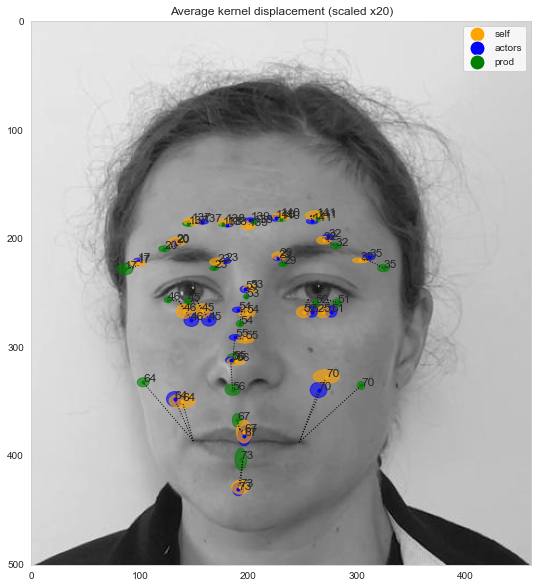

In [57]:
# visualize mean displacements on one actor (with circles marking confidence intervals on dot-product)
# and histograms on dot-product displacements for each landmark point

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# fetch neutral landmark positions for one actor
actor = 14
kernel_stats['x_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'x'), axis=1)
kernel_stats['y_neutral'] = kernel_stats.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'y'), axis=1)

fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1)
ax = fig.add_subplot(111)
scale = 20 #multiply kernel amplitude

task_colors = {'self':'orange',
              'actors':'blue',
              'prod':'green'}
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['orange','blue','green'])


for index, row in kernel_stats.iterrows():
    
    task_color = task_colors[row['task']]
    
    # display displaced
    g2=plt.scatter(row['x_neutral']+scale*row['delta_x_mean'],
                   row['y_neutral']+scale*row['delta_y_mean'], color=task_color, marker='.', zorder=3)
    
    ax.text(row['x_neutral']+scale*row['delta_x_mean'], 
            row['y_neutral']+scale*row['delta_y_mean'], str(int(row['point'])), fontsize=12)
    
    # display line between points
    plt.plot([row['x_neutral'],
              row['x_neutral']+scale*row['delta_x_mean']],
             [row['y_neutral'], 
              row['y_neutral']+scale*row['delta_y_mean']],
             color='black',linestyle=':',linewidth=1, zorder=2)
    
    # draw confidence interval as ellipse
    conf = Ellipse((row['x_neutral'] + scale*row['delta_x_mean'],
                    row['y_neutral'] + scale*row['delta_y_mean']),
                   width = scale*(row['delta_x_sup']-row['delta_x_inf']),
                   height = scale*(row['delta_y_sup']-row['delta_y_inf']),
                   facecolor = task_color,
                   edgecolor = task_color,
                   alpha = 0.6, 
                   zorder = 2)
    #note: to have ellipses with different x & y confidence intervals, use alternatively: 
    #width = scale*(row['delta_x_sup']-row['delta_x_inf']),height = scale*(row['delta_y_sup']-row['delta_y_inf']),
    
    ax.add_patch(conf)
   
from PIL import Image
fname = '../experiment/revcor-self/stims/Actor'+str(int(actor))+'/neutral.jpg'
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255, zorder=0)

#img = imread('../experiment/revcor-self/stims/Actor'+str(int(actor))+'/neutral.jpg')
#plt.imshow(img, zorder=0)
plt.title('Average kernel displacement (scaled x%d)'%scale)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], 
                          marker='o', 
                          markersize=15, 
                          color='w', 
                          markerfacecolor=value,
                          label=key) for key,value in task_colors.items()]
ax.legend(handles=legend_elements, loc='upper right')
ax.grid(False)

plt.savefig('./pics/three-kernel.jpg', format='jpg', dpi=600, transparent=True)


#### Comparison of PCA face features

##### Extract components

To quantify morphological differences between kernels, we then used principal component analysis (PCA) to re-encode each kernel along a set of more meaningful facial deviation patterns in the eye and lip regions, learned from the data. 

In [58]:
# load all kernels 
SUBJECTS=range(1,25)
TASKS = ['self','actors','prod']
subjects=[]
points = []
tasks = []
for subj in SUBJECTS:
    for point in POINTS: 
        for task in TASKS:
            subjects.append(int(subj))
            points.append(point)
            tasks.append(task)
kernels=pd.DataFrame.from_dict({'subj':subjects,
                                'point':points, 
                                'task':tasks})

kernels.loc[kernels['task']=='self',
            'delta_x'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-self/Subject%d.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)
kernels.loc[kernels['task']=='self',
            'delta_y'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-self/Subject%d.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)
kernels.loc[kernels['task']=='prod',
            'delta_x'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/production/Subject%d.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)
kernels.loc[kernels['task']=='prod',
            'delta_y'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/production/Subject%d.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)

kernels.loc[kernels['task']=='actors',
            'delta_x'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-actors/Subject%d_Average.txt'%(row['subj']),
                                                  row['point'],'x'), axis=1)

kernels.loc[kernels['task']=='actors',
            'delta_y'] = kernels.apply(lambda row:\
                                   get_coordinate('./kernels/revcor-actors/Subject%d_Average.txt'%(row['subj']),
                                                  row['point'],'y'), axis=1)


In [59]:
def plot_components(components, variance, n_components, scale, xlim, ylim):
    # fetch neutral landmark positions for one actor
    actor = 14
    components['x_neutral'] = components.apply(lambda row:\
                                       get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                  row['point'],'x'), axis=1)
    components['y_neutral'] = components.apply(lambda row:\
                                   get_coordinate('../experiment/revcor-self/stims/Actor%d/neutral.txt'%(actor),
                                                 row['point'],'y'), axis=1)

    fig = plt.figure(figsize=(20,20))
    #plt.subplots_adjust(hspace=0.1, wspace=0)

    for index_component, component in enumerate(range(n_components)):
    
        ax = fig.add_subplot(1,4,index_component+1)
        ax.grid(False)
    
        for index_point, row in components[components.component==component].iterrows():
    
            # display displaced
            g2=plt.scatter(row['x_neutral']+scale*row['delta_x'],
                   row['y_neutral']+scale*row['delta_y'], 
                       color='red', marker='.', zorder=3)
    
            ax.text(row['x_neutral']+scale*row['delta_x'], 
                row['y_neutral']+scale*row['delta_y'],
                str(int(row['point'])), fontsize=12)
    
            # display line between points
            plt.plot([row['x_neutral'],
                  row['x_neutral']+scale*row['delta_x']],
                 [row['y_neutral'], 
                  row['y_neutral']+scale*row['delta_y']],
                 color='red',linestyle=':',linewidth=1, zorder=2)
    
        from PIL import Image
        fname = '../experiment/revcor-self/stims/Actor'+str(int(actor))+'/neutral.jpg'
        image = Image.open(fname).convert("L")
        arr = np.asarray(image)
        plt.imshow(arr, cmap='gray', vmin=0, vmax=255, zorder=0)
        #plt.imshow(arr, zorder=0)
        
        plt.ylim(ylim)
        plt.xlim(xlim)
    
        plt.title('Component %d (%d%%)'%(component+1,np.floor(100*variance[index_component])))

We extracted 4 principal components (PCs) from the eye region (learned over the 72 displacements of the 4 eye landmarks in the N=24 individual kernels $\times$ 3 tasks), which we found corresponded approximately to facial action units AU7 (lid tightening), AU5 (lid raiser), AU6 (cheek raiser) and AU46 (wink). 

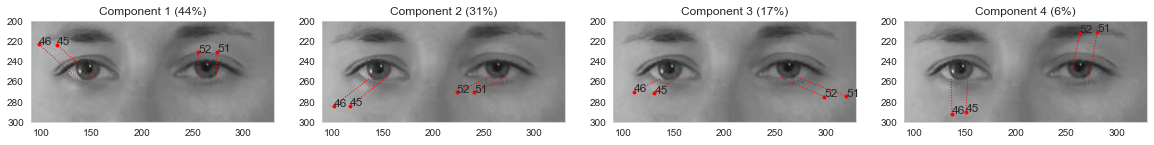

In [60]:
# compute 4 eye PCs
import numpy as np
from sklearn.decomposition import PCA
n_components=4
pca_eye = PCA(n_components)

points = EYE_POINTS
# unmelt all points coordinates as columns
kernels2 = kernels[kernels.point.isin(points)].pivot_table(index=['subj','task'], columns='point')
def concat(tup): return tup[0]+'_'+str(tup[1])
kernels2.columns = [concat(tup) for tup in kernels2.columns.values]
kernels2.reset_index(inplace=True)

# fit PCA
pca_eye.fit(kernels2[['delta_x_%d'%p for p in points]+['delta_y_%d'%p for p in points]])
components = pd.DataFrame(pca_eye.components_)
components.columns = ['delta_x_%d'%p for p in points]+['delta_y_%d'%p for p in points]
components['component'] = components.index

# melt points as values
delta_x = pd.melt(components,
        id_vars=['component'],
        value_vars=['delta_x_%d'%p for p in points],
        var_name='point', value_name='delta_x')
delta_x['point'] = delta_x['point'].transform(lambda x:int(x.split('_')[2]))
delta_y = pd.melt(components,
        id_vars=['component'],
        value_vars=['delta_y_%d'%p for p in points],
        var_name='point', value_name='delta_y')
delta_y['point'] = delta_y['point'].transform(lambda x:int(x.split('_')[2]))
components = delta_x.merge(delta_y.set_index(['component','point']),on=['component','point'])

plot_components(components, pca_eye.explained_variance_ratio_, n_components, -80, xlim=[90,330], ylim=[300,200])

plt.savefig('./pics/eye-pca.jpg', format='jpg', dpi=600, transparent=True)


Similarly, we extracted 4 PCs over the 4 mouth lip landmarks, which corresponded approximately to AU20 (lip stretcher), AU12 (lip corner puller), AU16 (lower lip depressor) and AU14 (dimpler).    

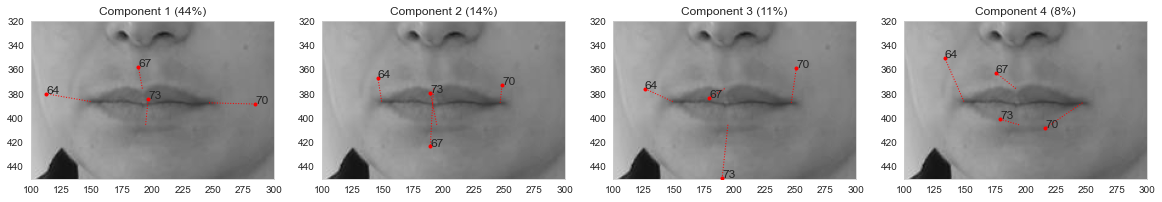

In [61]:
# compute 4 lip PCs
import numpy as np
from sklearn.decomposition import PCA
n_components=4
pca_lip = PCA(n_components)

points = LIP_POINTS
# unmelt all points coordinates as columns
kernels2 = kernels[kernels.point.isin(points)].pivot_table(index=['subj','task'], columns='point')
def concat(tup): return tup[0]+'_'+str(tup[1])
kernels2.columns = [concat(tup) for tup in kernels2.columns.values]
kernels2.reset_index(inplace=True)

# fit PCA
pca_lip.fit(kernels2[['delta_x_%d'%p for p in points]+['delta_y_%d'%p for p in points]])
components = pd.DataFrame(pca_lip.components_)
components.columns = ['delta_x_%d'%p for p in points]+['delta_y_%d'%p for p in points]
components['component'] = components.index

# melt points as values
delta_x = pd.melt(components,
        id_vars=['component'],
        value_vars=['delta_x_%d'%p for p in points],
        var_name='point', value_name='delta_x')
delta_x['point'] = delta_x['point'].transform(lambda x:int(x.split('_')[2]))
delta_y = pd.melt(components,
        id_vars=['component'],
        value_vars=['delta_y_%d'%p for p in points],
        var_name='point', value_name='delta_y')
delta_y['point'] = delta_y['point'].transform(lambda x:int(x.split('_')[2]))
components = delta_x.merge(delta_y.set_index(['component','point']),on=['component','point'])

plot_components(components, pca_lip.explained_variance_ratio_, n_components, -60, xlim=[100,300], ylim=[450,320])

plt.savefig('./pics/lip-pca.jpg', format='jpg', dpi=600, transparent=True)


In [62]:
# save PCs as features, linked to subj and tasks

scale = -1 # invert direction of pcs, to match figures above

lip_features= pd.DataFrame(pca_lip.transform(kernels2[['delta_x_%d'%p for p in points]+['delta_y_%d'%p for p in points]]))
lip_features.reset_index(inplace=True)#lip_features.columns=['LIP_PC1','LIP_PC2','LIP_PC3','LIP_PC4']
lip_features = pd.melt(lip_features,
        id_vars=['index'],
        value_vars=[i for i in range(n_components)],
        var_name='component', value_name='weight')
lip_features['type']='lip'
lip_features['weight']=scale * lip_features['weight']

lip_features=kernels2[['subj','task']].merge(lip_features,
               left_index=True, 
               right_on='index').drop(columns=['index'])


eye_features= pd.DataFrame(pca_eye.transform(kernels2[['delta_x_%d'%p for p in points]+['delta_y_%d'%p for p in points]]))
eye_features.reset_index(inplace=True)#lip_features.columns=['LIP_PC1','LIP_PC2','LIP_PC3','LIP_PC4']
eye_features = pd.melt(eye_features,
        id_vars=['index'],
        value_vars=[i for i in range(n_components)],
        var_name='component', value_name='weight')
eye_features['type']='eye'
eye_features['weight']=scale * eye_features['weight']

eye_features=kernels2[['subj','task']].merge(eye_features,
               left_index=True, 
               right_on='index').drop(columns=['index'])
features=lip_features.append(eye_features, ignore_index=True)



In [63]:
features.to_csv('data/PCA_features.csv')

##### Compare group distributions between tasks

We tested for morphological differences between the three types of kernels with separate repeated-measure ANOVAs on kernel weights along each of the 8 PCs, using kernel type (production, self perception, other perception) as within-factor (Bonferroni-corrected level $\alpha=.00625$). In the mouth region, the kernels significantly differed along the PC1 (lip stretcher) dimension (F(46,2)=56.09, p<.0001), with actual smiling behaviour (production) involving more horizontal stretching than self and actor perception kernels. In the eye region, the kernels also differed along PC1 (lid tightening; more in production, F(46,2)=56.62, p<.0001), PC2 (lid raiser; more in perception, F(46,2)=7.78, p=.001) and PC3 (cheek raiser; more in production, F(46,2)=12.86, p<.0001). 

In [64]:
features = pd.read_csv('data/PCA_features.csv', index_col=0)

for feature_type in ['lip','eye']: 
    print('%s features:'%feature_type.capitalize())
    for component in [0,1,2,3]: 
        
        aov = pg.rm_anova(data=features[(features.component==component)
                                    & (features.type==feature_type)],
                          dv='weight', 
                          within='task',
                          subject='subj',
                          detailed=True, 
                          effsize="np2")
        print('Component %d: F(%d,%d)=%.3f, p=%.4f'%(component,aov.DF[0],aov.DF[1],aov.F[0],aov['p-unc'][0]))

        #print(aov.round(3))
        

Lip features:
Component 0: F(2,46)=56.086, p=0.0000
Component 1: F(2,46)=2.276, p=0.1141
Component 2: F(2,46)=0.241, p=0.7868
Component 3: F(2,46)=3.962, p=0.0259
Eye features:
Component 0: F(2,46)=56.620, p=0.0000
Component 1: F(2,46)=7.776, p=0.0012
Component 2: F(2,46)=12.864, p=0.0000
Component 3: F(2,46)=2.332, p=0.1085


### Kernel comparisons between tasks at the individual level

To examine whether participants had similar perceptual strategies between self and other perception, and whether these corresponded to their individual smiling behaviour, we then computed correlations between the PC weights of the different types of kernels across the group of N=24 participants. 

In [65]:
features = pd.read_csv('data/PCA_features.csv', index_col=0)

In [66]:
# pivot tasks as columns for regression
features2 = features.pivot_table(index=['subj','type','component'], columns='task')
def concat(tup): return tup[0]+'_'+str(tup[1])
features2.columns = [concat(tup) for tup in features2.columns.values]
features2.reset_index(inplace=True)


In [67]:
def plot_regressions(task_x, task_y):
    
    components = list(features2.component.unique())
    
    fig = plt.figure(figsize=(20,10)); subplot=1
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

    print('%s vs %s:'%(task_x.capitalize(),task_y.capitalize()))
    for index_type, feature_type in enumerate(['lip','eye']):
    
        print('%s features:'%feature_type.capitalize())
    
        for component in components:
        
            ax = fig.add_subplot(2,4,subplot); subplot+=1
                
            ax=sns.regplot(data=features2[(features2.component==component)&
                                     (features2.type==feature_type)],
                           x='weight_'+task_x,
                           y='weight_'+task_y,
                           units='subj',
                           robust=True,
                           truncate=False)
        
            a= st.linregress(list(features2[(features2.component==component)&
                                     (features2.type==feature_type)]['weight_'+task_x]),
                         list(features2[(features2.component==component)&
                                     (features2.type==feature_type)]['weight_'+task_y]))
                         
    
            plt.title("%s%d\nR = %.3f p = %.4f"%(feature_type.capitalize(),
                                              component+1,
                                              a.rvalue,
                                              a.pvalue))
            ax.set_ylabel('%s'%task_y)
            ax.set_xlabel('%s'%task_x)
            ax.grid(False)
        
            # label points
            for i,point in features2[(features2.component==component)&
                                     (features2.type==feature_type)].iterrows():
                ax.text(point['weight_'+task_x]+.1, point['weight_'+task_y], str(point['subj']))

        
            print('Component %d: R=%.3f, p=%.4f %s'%(component+1,
                                                     a.rvalue,
                                                     a.pvalue,
                                                     '(*)' if a.pvalue < 0.05 else ''))

#### Self and other representations

Participants' self and other representations correlated for 3 of the 4 lip principal components (PC1: R=0.588, p=.0025; PC2: R=0.555, p=.0049; PC3: R=0.518, p=.0095; Bonferroni-corrected $\alpha=.00625$) as well as, marginally, in one eye component (PC4: R=0.424, p=.0390; albeit non-significantly). This indicates that, at least in the mouth region, participants used similar perceptual representations to judge smiles of affiliation in both the self and other: participants who internally represented their own smiling face with e.g. wider lip stretch also represented others with wider smiles. 

Self vs Actors:
Lip features:
Component 1: R=0.588, p=0.0025 (*)
Component 2: R=0.555, p=0.0049 (*)
Component 3: R=0.518, p=0.0095 (*)
Component 4: R=0.188, p=0.3793 
Eye features:
Component 1: R=0.330, p=0.1153 
Component 2: R=-0.280, p=0.1859 
Component 3: R=0.117, p=0.5866 
Component 4: R=0.424, p=0.0390 (*)


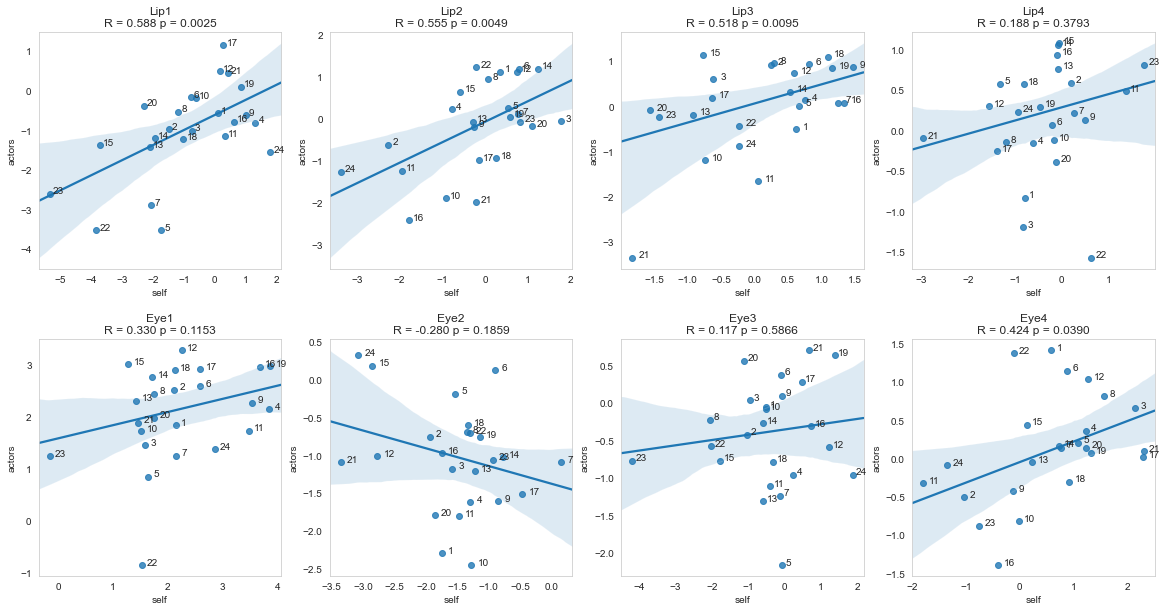

In [68]:
plot_regressions('self','actors')

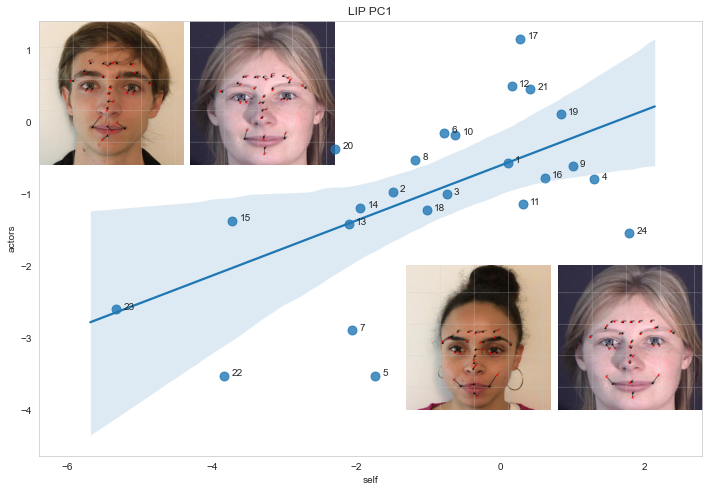

In [69]:
fig = plt.figure(figsize=(15,8))
ax=sns.regplot(data=features2[(features2.component==0)&
                                     (features2.type=='lip')],
               x='weight_self',
               y='weight_actors',
               units='subj',
               robust=True,
               truncate=False,
               scatter_kws={"s": 80})
# label points
for i,point in features2[(features2.component==0)&
                         (features2.type=='lip')].iterrows():
     ax.text(point['weight_self']+.1, point['weight_actors'], str(point['subj']))

ax.set_ylabel('actors')
ax.set_xlabel('self')
ax.grid(False)

img = imread('./kernels/revcor-self/Subject23.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(-6.4,-4.4,-0.6,1.4))

img = imread('./kernels/revcor-actors/Subject23_Average_on_Actor1.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(-4.3,-2.3,-0.6,1.4))

img = imread('./kernels/revcor-self/Subject19.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(-1.3,0.7,-4,-2))

img = imread('./kernels/revcor-actors/Subject19_Average_on_Actor1.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(0.8,2.8,-4,-2))

plt.title('LIP PC1')

plt.savefig('./pics/correlation_1.jpg', format='jpg', dpi=600, transparent=True)


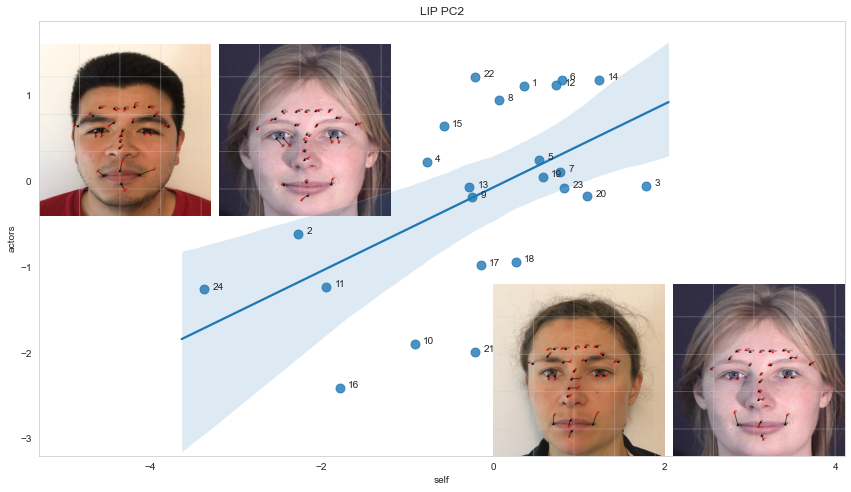

In [70]:
fig = plt.figure(figsize=(15,8))
ax=sns.regplot(data=features2[(features2.component==1)&
                                     (features2.type=='lip')],
               x='weight_self',
               y='weight_actors',
               units='subj',
               robust=True,
               truncate=False,
               scatter_kws={"s": 80})
# label points
for i,point in features2[(features2.component==1)&
                         (features2.type=='lip')].iterrows():
     ax.text(point['weight_self']+.1, point['weight_actors'], str(point['subj']))

ax.set_ylabel('actors')
ax.set_xlabel('self')
ax.grid(False)

img = imread('./kernels/revcor-self/Subject24.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(-5.3,-3.3,-0.4,1.6))

img = imread('./kernels/revcor-actors/Subject24_Average_on_Actor1.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(-3.2,-1.2,-0.4,1.6))

img = imread('./kernels/revcor-self/Subject14.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(-0,2,-3.2,-1.2))

img = imread('./kernels/revcor-actors/Subject14_Average_on_Actor1.png')
img = img[100:600,120:580,:]
plt.imshow(img, zorder=0, extent=(2.1,4.1,-3.2,-1.2))

plt.title('LIP PC2')

plt.savefig('./pics/correlation_2.jpg', format='jpg', dpi=600, transparent=True)



#### Self-other representations and production

In contrast, there was strikingly no correlation between the participants' self perception and production kernels, on any of the lip (all ps$>$0.31) and eye region PCs (all ps $>$ 0.14), nor between the participants' other perception and production kernels (lip: all ps $>$0.34; eye: all ps $>$0.08). This indicates that participants' internal representations of how they thought of themselves and others are not directly correlated with how smiles are really produced. For instance, all produced smiles have a wider stretch than in perception, but over the group there was no systematic relation between the individual degree of stretch between production and perception. 

In [ ]:
plot_regressions('prod','self')

Prod vs Self:
Lip features:
Component 1: R=0.153, p=0.4768 
Component 2: R=0.215, p=0.3122 
Component 3: R=-0.012, p=0.9563 
Component 4: R=-0.158, p=0.4597 
Eye features:


In [ ]:
plot_regressions('prod','actors')

In short, kernel comparisons at the individual level provides psychophysical evidence that participants internally represent others using similar representations as they use to perceive themselves, but also that these self-representations are not significantly correlated with how they really produced smiles. 

### Correlations with individual differences in empathy and alexithymia

To examine whether participants had similar perceptual strategies between self and other perception, and whether these corresponded to their individual smiling behaviour, we then computed correlations between the PC weights of the different types of kernels across the group of N=24 participants. 

#### Associations with individual kernel morphology

We first tested for possible statistical associations between individual kernel morphology (e.g., whether participants see themselves smiling with wider lip stretch, using the self-perception kernel weights along lip PC1) and individual differences in alexithymia and empathy, using separate correlations for each PC, kernel type (production, self, other) and questionnaire. 

In [ ]:
# load data 
features = pd.read_csv('data/PCA_features.csv', index_col=0)
questions = pd.read_csv('data/questionnaire.csv', index_col=0)
data = features.merge(questions[['subj','TAS20','BESA','warmth','dominance']], on='subj')

In [ ]:
from itertools import product

tasks = list(data.task.unique())
measures = ['TAS20','BESA','warmth','dominance']
types = list(data.type.unique())
components = list(data.component.unique())

for task in tasks: 
    print('\nTASK:%s'%task.upper())
    for type_feature in types: 
        print('%s'%type_feature.upper())
        for measure,component in product(measures,components):
            a= st.linregress(list(data[(data.task==task)
                                       &(data.type==type_feature)
                                      &(data.component==component)]['weight']),
                             list(data[(data.task==task)
                                       &(data.type==type_feature)
                                      &(data.component==component)][measure]))
            print("%s vs %s: R = %.3f p = %.4f %s"%(measure,type_feature.upper()+str(component),
                                            a.rvalue,a.pvalue, '(*)' if a.pvalue < 0.05 else ''))
    

As could be expected, there was no evidence that individual alexithymia and empathy influenced how participants smiled (Production: all ps $>$.04, $\alpha_corr=.003$), or internally represented smiles either in the self (all ps $>$ .11) or in others (all ps $>$.056).

In [ ]:
def plot_regress(task,type_feature,component,measure): 
    
    ax=sns.regplot(data=data[(data.task==task)&
                         (data.type==type_feature)&
                         (data.component==component)],
               x=measure,
               y='weight',
               units='subj',
               robust=True,
               truncate=False,
               scatter_kws={"s": 80})
    # label points
    for i,point in data[(data.task==task)&
                         (data.type==type_feature)&
                         (data.component==component)].iterrows():
        ax.text(point[measure]+.1, point['weight'], str(point['subj']))
        
    a= st.linregress(list(data[(data.task==task)&
                         (data.type==type_feature)&
                         (data.component==component)][measure]),
                list(data[(data.task==task)&
                         (data.type==type_feature)&
                         (data.component==component)]['weight']))
                             
    plt.title("R = %.3f p = %.4f"%(a.rvalue,a.pvalue))

    ax.set_ylabel('%s%s'%(type_feature.upper(),component))
    ax.set_xlabel(measure)
    ax.grid(False)

fig = plt.figure(figsize=(20,10))
plt.subplot(131)
plot_regress(task='prod',type_feature='lip',component=1,measure='TAS20')
plt.subplot(132)
plot_regress(task='prod',type_feature='lip',component=0,measure='dominance')
plt.subplot(133)
plot_regress(task='prod',type_feature='eye',component=3,measure='warmth')



#### Correlation with similarity of kernel morphology between tasks

We then tested for possible associations between the *similarity* of kernel morphologies between tasks (e.g. the extent to which participants internally represented themselves smiling with a similar morphology as their actual smiling behaviour, computed as the difference between production and self-perception kernel weights along each face PC) and individual characteristics. 

In [ ]:
features = pd.read_csv('data/PCA_features.csv', index_col=0)
# pivot tasks as columns for regression
features2 = features.pivot_table(index=['subj','type','component'], columns='task')
def concat(tup): return tup[0]+'_'+str(tup[1])
features2.columns = [concat(tup) for tup in features2.columns.values]
features2.reset_index(inplace=True)

questions = pd.read_csv('data/questionnaire.csv', index_col=0)
data = features2.merge(questions[['subj','TAS20','BESA','warmth','dominance']], on='subj')

#### is alexithymia related to the similarity between production and self-representation ?   

Although these associations were limited and our statistical power was only moderate (achieved power $1-\beta$=.81 for $R$=0.5, $N$=24), they were all in our predicted directions: first, we found a significant (albeit non-corrected) positive correlation between the distance of production and self-perception kernels along lip PC1 (lip stretcher) and participant alexithymia: R = 0.453, p=.026, corrected $\alpha=.00625$. This suggests that participants scoring high on alexithymia had representations of their own smiling face that differed more from their actually produced smiles than participants low on alexithymia. In contrast, alexithymia did not associate with any measure of distance between self and other kernels. 

In [ ]:
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
# zscore TAS and weights
data['z_TAS20'] = zscore(data['TAS20'])
data['z_weight_self'] = data.groupby(['type','component'])['weight_self'].transform(zscore) 
data['z_weight_prod'] = data.groupby(['type','component'])['weight_prod'].transform(zscore) 
data['self-prod'] = np.abs(data['z_weight_self']-data['z_weight_prod'])

In [ ]:
types = list(data.type.unique())
components = list(data.component.unique())

for type_feature in types: 
    print('%s'%type_feature.upper())
    d = data[(data.type==type_feature)].groupby(['subj']).agg({'self-prod':'mean',
                                             'z_TAS20':'mean'}).reset_index()
    a= st.linregress(list(d['self-prod']),
                     list(d['z_TAS20']))
    print("%s vs TAS20: R = %.3f p = %.4f %s"%(type_feature.upper(),
                                            a.rvalue,a.pvalue, '(*)' if a.pvalue < 0.05 else ''))
    

In [ ]:
types = list(data.type.unique())
components = list(data.component.unique())

for type_feature in types: 
    print('%s'%type_feature.upper())
    for component in components: 
        a= st.linregress(list(data[(data.type==type_feature)
                                   &(data.component==component)]['self-prod']),
                             list(data[(data.type==type_feature)
                                   &(data.component==component)]['z_TAS20']))
        print("%s vs TAS20: R = %.3f p = %.4f %s"%(type_feature.upper()+str(component),
                                            a.rvalue,a.pvalue, '(*)' if a.pvalue < 0.05 else ''))
    

In [ ]:
ax=sns.regplot(data=data[(data.type=='lip')&(data.component==0)],
               x='z_TAS20',
               y='self-prod',
               units='subj',
               robust=True,
               truncate=False)

plt.savefig('./pics/alexithymia.jpg', format='jpg', dpi=600, transparent=True)


#### is empathy related to the similarity between self- and other-representation ?   

Second, although self and other kernels were tightly correlated for most facial PCs, their difference along one non-correlated component (lip PC4, R=0.188, p=.38) was significantly, and negatively, correlated with participant empathy: R = -0.550, p=.0053, corrected $\alpha=.00625$ . This suggests that the sensory representations of self and others in participants with more empathy were more closely matched on fine aspects of smile morphology (here, AU14 - *dimpler*). Contrary to alexithymia, empathy did not associate with any measure of distance between self and production kernels. 

In [ ]:
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
# zscore TAS and weights
data['z_BESA'] = zscore(data['BESA'])
data['z_weight_self'] = data.groupby(['type','component'])['weight_self'].transform(zscore) 
data['z_weight_actors'] = data.groupby(['type','component'])['weight_actors'].transform(zscore) 
data['self-actors'] = np.abs(data['z_weight_self']-data['z_weight_actors'])

In [ ]:
types = list(data.type.unique())
components = list(data.component.unique())

for type_feature in types: 
    print('%s'%type_feature.upper())
    d = data[(data.type==type_feature)].groupby(['subj']).agg({'self-actors':'mean',
                                             'z_BESA':'mean'}).reset_index()
    a= st.linregress(list(d['self-actors']),
                     list(d['z_BESA']))
    print("%s vs TAS20: R = %.3f p = %.4f %s"%(type_feature.upper(),
                                            a.rvalue,a.pvalue, '(*)' if a.pvalue < 0.05 else ''))
    

In [ ]:
types = list(data.type.unique())
components = list(data.component.unique())

for type_feature in types: 
    print('%s'%type_feature.upper())
    for component in components: 
        a= st.linregress(list(data[(data.type==type_feature)
                                   &(data.component==component)]['self-actors']),
                             list(data[(data.type==type_feature)
                                   &(data.component==component)]['z_BESA']))
        print("%s vs BESA: R = %.3f p = %.4f %s"%(type_feature.upper()+str(component),
                                            a.rvalue,a.pvalue, '(*)' if a.pvalue < 0.05 else ''))
    

In [ ]:
ax=sns.regplot(data=data[(data.type=='lip')&(data.component==3)],
               x='z_BESA',
               y='self-actors',
               units='subj',
               robust=True,
               truncate=False)

plt.savefig('./pics/empathy.jpg', format='jpg', dpi=600, transparent=True)


### Behavioral consequences of kernel morphology on perceived smile intensity

Finally, to validate whether individual differences in kernel morphology have behavioral consequences on how participants evaluate smiles, we applied the N=24 individual smile kernels learned from the *Other perception* task to 6 additional actor photographs. In a separate rating task, we then let the same N=24 participants judge the intensity of affiliation in manipulated photographs which, without their knowing, represented either their (1 trial per actor) or everybody else's kernels (23 images per actor).  
Manipulated photographs were presented in pairs with a single non-manipulated photograph (always the same for a given actor), to which participants had to compare them. 

#### Load data

In [ ]:
data_dir = 'data/validation/'
data_files = glob.glob(data_dir+"results_Subj*.csv.gz")
data = pd.DataFrame()
for data_file in data_files:
    participant_data = pd.read_csv(data_file, sep = ',', decimal='.', header='infer')
    data = data.append(participant_data, ignore_index=True)

Each subj did 144 trials (block1) + 4 training trials (block0), which are 6 actors x all 24 kernels (incl. themselves). So 6 trials on self-kernel vs 6x23 trials on other-kernels. 

In [ ]:
data[data.block==1].groupby(['subj']).agg({'trial':'nunique','actor':'nunique','kernel_subj':'nunique'}).head(5)

In [ ]:
data=data[data.block==1]

#### Main effects on kernel ratings

As expected, participants judged photographs manipulated with smile kernels overall more intensely affiliative than the corresponding non-manipulated photographs (M=6.49>5, t(24) = 17.465, p $<$.001).

In [ ]:
sns.boxplot(x=data['response'])
responses = list(data.groupby(['subj'])['response'].mean().reset_index()['response'])
print(np.mean(responses))
a = st.ttest_1samp(responses,5.0)
print("t(%d) = %.3f, p = %.4f %s"%(len(responses),
                                   a.statistic,
                                   a.pvalue,
                                   '(*)' if a.pvalue < 0.05 else ''))

#### Are ratings influenced by kernel similarity to self

However, observers ratings of stimuli constructed with other participants' kernels differed according to how well they matched their own kernel. For each participant, we ranked all n=24 stimuli by increasing distance to the participant's own kernel, and found that the individual slopes linking (normalized) ratings of affiliation to the distance between the presented kernel and the observer's own kernel were all significantly negative (rm-correlation: r(527)=-0.35, 95\% CI \[-0.42,-0.27\], p=2e-16). In other words, observers judged facial affiliation using their own kernel as a yardstick: the more stimuli matched the observers' own reverse-correlation kernels, the more affiliative observers thought they were. 

In [ ]:
data_dir = 'data/validation/'
data_files = glob.glob(data_dir+"results_Subj*.csv.gz")
data = pd.DataFrame()
for data_file in data_files:
    participant_data = pd.read_csv(data_file, sep = ',', decimal='.', header='infer')
    data = data.append(participant_data, ignore_index=True)

In [ ]:
# tag ratings of self kernel
data["self"]=0
data.loc[data.subj == data.kernel_subj,'self']=1
# add self-response for (subj,actor)
data_self = data[data.self==1].groupby(['subj','actor'])['response'].mean().reset_index()
data = data.merge(data_self, left_on=['subj','actor'], right_on=['subj','actor'],suffixes=('','_self'))
data['delta_response']=data['response']-data['response_self']

In [ ]:
# compute similarity of PC weights between self kernels
features = pd.read_csv('data/PCA_features.csv', index_col=0)
features = features[features.task=='self']
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
features['z_weight'] = features.groupby(['type','component'])['weight'].transform(zscore)

sims = features.merge(features, how='outer', left_on=['type','component'], right_on=['type','component'])
sims.rename(columns={'subj_x':'kernel_1',
                     'subj_y':'kernel_2',
                     'z_weight_x':'z_weight_1',
                     'z_weight_y':'z_weight_2'}, inplace=True) 
sims.drop(columns=['task_x','task_y','weight_x','weight_y'], inplace=True)

sims['dist']=np.abs(sims.z_weight_1 - sims.z_weight_2)

In [ ]:
# merge with kernel ratings
data_sim = data.merge(sims, left_on=['subj','kernel_subj'], right_on=['kernel_1','kernel_2'])

In [ ]:
fig = plt.figure(figsize=(40,20))

d = data_sim[(data_sim.self==0)].groupby(['kernel_subj','subj'])['dist','delta_response'].mean().reset_index()


sns.lmplot(x='dist',
           y='delta_response',
           data=d, 
          markers=None,
           hue='subj',
           legend=True, legend_out=False,scatter_kws={"s": 10},
          height=8, aspect=1)

ax=sns.lineplot(x='dist',
                  y = 'delta_response',
                  units='subj',
                  data=d,color='k', 
             alpha=0.1,
                  legend=False, 
                  estimator=None
                 )
ax.set_zorder(-1)

plt.yticks(size=20)
plt.ylabel('perceive affiliation, relative to self-kernel', size=20)
plt.xticks(size=20)
plt.xlabel('distance to self-kernel', size=20)
plt.legend(title='participants')

plt.legend(loc=8, ncol=8)

print(pg.rm_corr(data=d, x='dist', y='delta_response', subject='subj'))
        #pg.plot_rm_corr(data=d, x='dist', y='delta_response', subject='subj')
    
plt.savefig('./pics/all_subj.jpg', format='jpg', dpi=600, transparent=True)


In [ ]:
import pingouin as pg

fig = plt.figure(figsize=(40,20))

d = data_sim[data_sim.self.isin([0,1])].groupby(['kernel_subj','subj','trial'])['dist', 'delta_response'].mean().reset_index()

d=d[d.subj==14]

sns.lmplot(x='dist',
           y='delta_response',
           data=d, 
           units='trial',
           y_jitter=0.2,
           legend=True, legend_out=False,scatter_kws={"s": 50},
          height=8, aspect=2)

ax=sns.lineplot(x='dist',
                  y = 'delta_response',
                  data=d,color='k', 
             alpha=0.2,
                  legend=False, 
                 )
ax.set_zorder(-1)

plt.ylim([-4,5])
plt.yticks(size=20)
plt.ylabel('perceive affiliation, relative to self-kernel', size=20)
plt.xticks(size=20)
plt.xlabel('distance to self-kernel', size=20)

plt.savefig('./pics/subj14.jpg', format='jpg', dpi=600, transparent=True)
 

#print(pg.rm_corr(data=d, x='dist', y='delta_response', subject='subj'))
        #pg.plot_rm_corr(data=d, x='dist', y='delta_response', subject='subj')